In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Edits (major):

# changed params file to boxsize 120 arcmin, dx = 1 for 2 degree patch, otherwise noise cov and pinv are taking 
# up too much space
# covariance matrix definition changed to the one below

In [3]:
import numpy as np, sys, os, scipy as sc, healpy as H, warnings, pickle, gzip
sys_folder = '../modules/'
sys.path.append(sys_folder)

import flatsky, tools, misc, moving_lens, inpaint, foregrounds as fg

import scipy.ndimage as ndimage
import matplotlib.cbook
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

from colossus.cosmology import cosmology
from colossus.halo import concentration, mass_defs
cosmology.setCosmology('planck15')
from astropy.cosmology import FlatLambdaCDM

%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
rcParams["figure.facecolor"] = 'white'
cmap = cm.RdYlBu_r

In [4]:
#others
perform_inpainting = False #True
use_pol_for_inpainting = False
mask = None
perform_oned_fitting = 1   

In [5]:
# read params file, if we need it

# params or supply a params file
paramfile = 'params_bullter_cluster.ini'

param_dict = misc.fn_get_param_dict(paramfile)

if not perform_oned_fitting:
    param_dict['boxsize'], param_dict['dx'] = 120., 2.

boxsize, dx = param_dict['boxsize'], param_dict['dx']
boxsize_am = boxsize
dls_file = param_dict['dls_file']
lmax, nside =  param_dict['lmax'],  param_dict['nside']
mask_file = param_dict['mask_file']

In [6]:
#get ra, dec or map-pixel grid
nx = int(boxsize_am/dx)
mapparams = [nx, nx, dx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx

ra_for_grid = np.linspace(x1,x2, nx)/60.
dec_for_grid = np.linspace(x1,x2, nx)/60.
ra_grid, dec_grid = np.meshgrid(ra_for_grid,dec_for_grid)

In [7]:
#read Cls now
if (0):#not use_pol_for_inpainting:
    el, dl = np.loadtxt(dls_file, usecols = [0,1], unpack = 1)
else:
    el, dl_tt, dl_ee, dl_bb, dl_te  = np.loadtxt(dls_file, unpack = 1)
    dl_all = np.asarray([dl_tt, dl_ee, dl_bb, dl_te])

dl_fac = el * (el + 1) / 2 / np.pi
cl_all = dl_all / dl_fac * 1e12
cl_tt, cl_ee, cl_bb, cl_te = cl_all
print(len(el), cl_tt.shape)

27658 (27658,)


In [8]:
# Set up beam

beamval = 1.2 #arcmins
bl2d = tools.get_bl(beamval, el, make_2d = 1, mapparams = mapparams)

In [9]:
# Set up noise

noiseval = 2.0 #uK-arcmin
noofsims_for_cov = 1000 #1500

nl = tools.get_nl(noiseval, el)

In [10]:
# Set up sims for noise covariance matrix

noise_sims = list()

for i in tqdm(range(noofsims_for_cov)):
    noise_map = flatsky.make_gaussian_realisation(mapparams, el, nl)
    noise_sims.append(noise_map)
    
npix = nx ** 2
noise_sims = np.asarray(noise_sims).flatten().reshape(noofsims_for_cov, npix)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 462.52it/s]


In [11]:
# ask -- the calcCov function in this version of tools uses sample covariance not population covariance??
# also using calcCov takes up too much memory space (26GB +) for such a numpy matrix. I used direct matmul instead.
# verify that this is a viable alternative; still a very big matrix.

noise_cov = np.matmul(noise_sims.T , noise_sims) / (noofsims_for_cov)
noise_cov.shape

(14400, 14400)

---------------

In [108]:
# Simulate the Moving Lens signal

# There are 2 clusters in Bullet cluster
M200c_bullet_1, M200c_bullet_2 = 1.5e15, 1.5e14
redshift_1, redshift_2 = 0.296, 0.296
#redshift_1, redshift_2 = 2., 2.
v_phi_1, v_th_1 = 0., 4500.
phi_1, theta_1 = 0., 0.
v_phi_2, v_th_2 = 0., 4500. 
phi_2, theta_2 = 0., 0.

M200c = [M200c_bullet_1]#, M200c_bullet_2]
redshift = [redshift_1]#, redshift_2]
v_phi = [v_phi_1]#, v_phi_2]
v_th = [v_th_1]#, v_th_2]    
phi = [phi_1]#, phi_2]
theta = [theta_1]#, theta_2]

# Run 1 simulation for now
noofclus = len(M200c)

In [109]:
# get the moving lens dipole
ra_list = dec_list = np.zeros(len(M200c)) #cluster always at centre
mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, M200c, redshift, v_phi, v_th, param_dict, bl = bl2d)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)
if (1): #repeat the same for all sims
    print(noofclus)
    mvl_arr = np.repeat(mvl_arr, noofclus, axis = 0)
    vel_dir_arr = np.repeat(vel_dir_arr, noofclus, axis = 0)
    vel_mag_arr = np.repeat(vel_mag_arr, noofclus, axis = 0)
    M200c = np.repeat(M200c, noofclus, axis = 0)
    redshift = np.repeat(redshift, noofclus, axis = 0)
    v_phi = np.repeat(v_phi, noofclus, axis = 0)
    v_th = np.repeat(v_th, noofclus, axis = 0)
    phi = np.repeat(phi, noofclus, axis = 0)
    theta = np.repeat(theta, noofclus, axis = 0)
print(mvl_arr.shape, vel_dir_arr.shape, vel_mag_arr.shape)

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=15.000, z=0.30
		time taken for gettting deflection vector = 4.0320555369059247e-05
check me. 
		time taken for get dot product = 2.570947011311849e-06
(1, 120, 120) (1,) (1,)
1
(1, 120, 120) (1,) (1,)


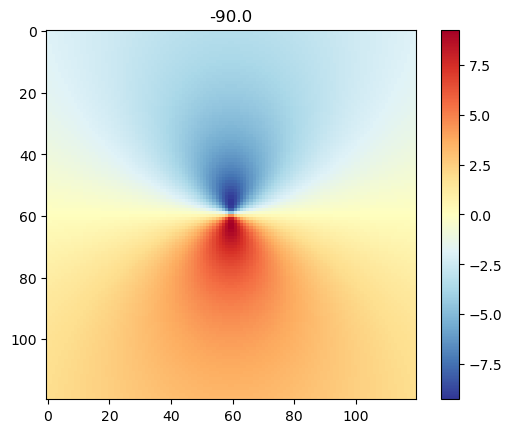

In [110]:
plt.imshow(mvl_arr[0], cmap = cmap); colorbar(); title(vel_dir_arr[0]); show()

-----------------

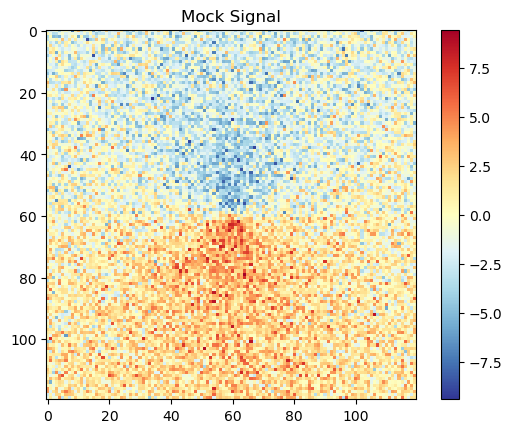

In [139]:
# Make a mock

ml_signal = mvl_arr[0]
noise_signal = flatsky.make_gaussian_realisation(mapparams, el, nl)
mock_signal = ml_signal + noise_signal
plt.imshow(mock_signal, cmap = cmap); colorbar(); title("Mock Signal"); show()

In [141]:
# Attempt a simple Emcee with amplitude of ML signal(even though there's just one param here :/ but at least it samples the
# distribution)

# To save shallow copy space, use global memory for now
cov = noise_cov
# cov_inv = np.linalg.pinv(cov)
data = mock_signal

def log_likelihood(amplitude):

    d = data.flatten() ## - np.mean(MAP.flatten())
    m = amplitude * ml_signal.flatten() ## - np.mean(MODEL.flatten())
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(amplitude):
    if (amplitude < 10) & (amplitude > -10):
        return 0.0     # permit
    return -np.inf     # do not permit

def log_probability(amplitude):
    prior = log_prior(amplitude)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(amplitude)


In [153]:
sample_amp = np.linspace(-10, 10, 2000)
likelihood = [log_likelihood(amp) for amp in tqdm(sample_amp)]

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:50<00:00, 18.11it/s]


In [161]:
like = likelihood - max(likelihood)
like = np.exp(like)
like/=max(like)
amp_mode=sample_amp[np.argmax(like)]

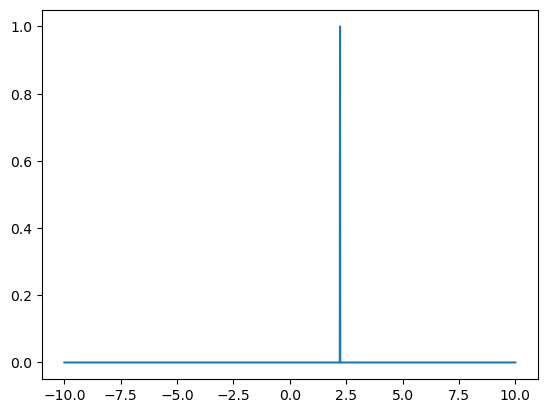

In [155]:
plt.plot(np.linspace(-10, 10, 2000), like)

In [ ]:
# Then try using emcee

from multiprocessing import Pool

initial = np.random.rand(32, 1) + 0.5  # centered around an amplitude of 1
nwalkers, ndim = initial.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool)
    burn_in = sampler.run_mcmc(initial, 100, progress = "notebook")
    sampler.reset()
    result = sampler.run_mcmc(burn_in, 1000, progress = 'notebook')
    samples = sampler.get_chain(flat = True)

In [41]:
samples_flat = samples.flatten()

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

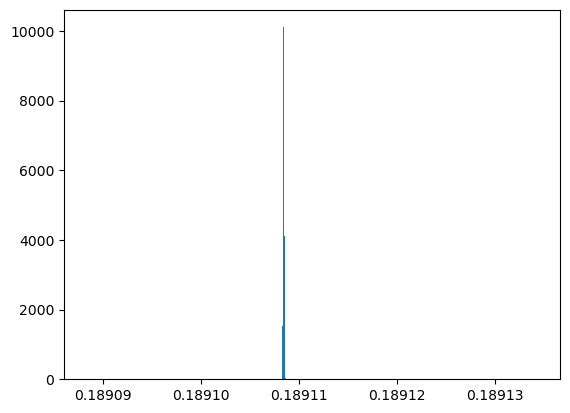

In [50]:
bins, plt.hist(samples.flat, bins = 1000)

In [53]:
sixteen = np.percentile(samples_flat, 16.)
eightyfour = np.percentile(samples_flat, 84.)
mean = np.percentile(samples_flat, 50.) # not really mean; change later
lowerr = mean - sixteen
higherr = eightyfour - mean

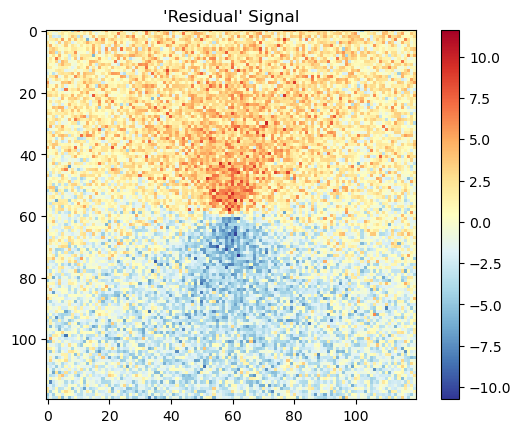

In [183]:
plt.imshow(mock_signal - amp_mode*ml_signal, cmap = cmap); colorbar(); title("\'Residual\' Signal"); show()

---------------

In [113]:
# Attempt a simple Emcee with mass and velocity characteristics (2 params)

# To save shallow copy space, use global memory for now
cov = noise_cov
# cov_inv = np.linalg.pinv(cov)
data = mock_signal

def log_likelihood(theta):
    
    velocity, mass = theta
    d = data.flatten() ## - np.mean(MAP.flatten())
    
    v_phi = [v_phi_1]
    phi = [phi_1]
    theta = [theta_1]
    redshift = [redshift_1]
    
    M200c = [mass]
    v_th = [velocity]
    
    noofclus = len(M200c)
    ra_list = dec_list = np.zeros(len(M200c))
    
    mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, M200c, redshift, v_phi, v_th, param_dict, bl = bl2d)
    m = mvl_arr[0].flatten()
    diff = d - m
    
    return -0.5 * np.asarray( np.dot(diff.T, np.dot( cov_inv, diff ))).squeeze()

def log_prior(theta):
    velocity, mass = theta
    if (velocity < 6000) & (velocity > 3000) & (mass < 1.5e16) & (mass > 1.5e14):
        return 0.0     # permit
    return -np.inf     # do not permit

def log_probability(theta):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return -np.inf
    return prior + log_likelihood(theta)


In [114]:
v_init = np.random.rand(32, 1)*500 + 4500
m_init = np.random.rand(32, 1)*5e14 + 1.5e15
initial = np.hstack([v_init, m_init])

In [115]:
# Try using emcee

from multiprocessing import Pool

nwalkers, ndim = initial.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool = pool)
    burn_in = sampler.run_mcmc(initial, 100, progress = "notebook")
    sampler.reset()
    result = sampler.run_mcmc(burn_in, 300, progress = 'notebook')
    samples = sampler.get_chain(flat = True)

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole now





0.0
0.0 0.00.00.00.0 0.00.00.0 0.0   
 0.00.00.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=15.398, z=0.30 


i=0: (ra,dec)=(0.000,0.000), mass=15.496, z=0.300.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=16.824, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=19.919, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=18.427, z=0.30

0.0


i=0: (ra,dec)=(0.000,0.000), mass=18.059, z=0.30
  0.0i=0: (ra,dec)=(0.000,0.000), mass=18.468, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=17.502, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=16.963, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=19.788, z=0.300.0
		time taken for gettting deflection vector = 0.00012293259302775065		time taken for gettting deflect

  0%|          | 0/100 [00:00<?, ?it/s]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

get moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole now0.0

0.0
 0.0
0.0 0.00.0
 0.00.00.00.0 0.0  0.0 0.00.00.0   
0.00.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=18.144, z=0.30  

0.0i=0: (ra,dec)=(0.000,0.000), mass=16.290, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=19.208, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=13.825, z=0.30
0.00.0



i=0: (ra,dec)=(0.000,0.000), mass=16.342, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=22.150, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=15.464, z=0.30

		time taken for gettting deflection vector = 7.799863815307617e-05i=0: (ra,dec)=(0.000,0.000), mass=16.306, z=0.30



		time taken for gettting deflection vector = 7.753769556681314e-05
i=0: (ra,dec)=(0.000,0.000), mass=13.318, z=0.30
i=0: (

i=0: (ra,dec)=(0.000,0.000), mass=19.498, z=0.30		time taken for gettting deflection vector = 9.206930796305339e-05

		time taken for gettting deflection vector = 0.00018866459528605144
check me. 
get moving lens dipole now		time taken for get dot product = 2.6373068491617837e-05

0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=17.388, z=0.30
		time taken for gettting deflection vector = 9.72588857014974e-05get moving lens dipole now

0.0check me.  
0.0check me. 		time taken for get dot product = 1.3073285420735677e-06

i=0: (ra,dec)=(0.000,0.000), mass=17.536, z=0.30check me. 

check me. 		time taken for get dot product = 3.4797191619873044e-05		time taken for get dot product = 2.5828679402669272e-06



		time taken for get dot product = 1.3589859008789062e-05check me. 

		time taken for gettting deflection vector = 0.00030910174051920574
		time taken for get dot product = 9.191036224365234e-06
check me. 
		time taken for get dot product = 0.0009429534276326497
check me. 
		time taken for g

		time taken for gettting deflection vector = 8.671283721923828e-050.0
		time taken for gettting deflection vector = 8.695522944132486e-05i=0: (ra,dec)=(0.000,0.000), mass=15.322, z=0.30		time taken for gettting deflection vector = 9.694496790568034e-05i=0: (ra,dec)=(0.000,0.000), mass=14.830, z=0.30		time taken for gettting deflection vector = 7.768472035725911e-05		time taken for gettting deflection vector = 7.422367731730143e-05		time taken for gettting deflection vector = 8.279085159301758e-05		time taken for gettting deflection vector = 7.863839467366536e-05



		time taken for gettting deflection vector = 0.00022898515065511066


		time taken for gettting deflection vector = 8.343855539957682e-05
i=0: (ra,dec)=(0.000,0.000), mass=7.887, z=0.30

		time taken for gettting deflection vector = 8.908907572428386e-05



		time taken for gettting deflection vector = 7.518927256266276e-05		time taken for gettting deflection vector = 0.00010564724604288737

check me. 
		time taken for get

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.00.0 0.00.0

0.0 
get moving lens dipole now
 0.0
0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=12.117, z=0.30 
get moving lens dipole now0.0 0.0

0.00.00.0 0.00.0 		time taken for gettting deflection vector = 7.223685582478842e-050.0 0.0  i=0: (ra,dec)=(0.000,0.000), mass=17.298, z=0.300.00.0



0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=17.884, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=16.252, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=13.939, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=11.079, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=16.694, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=16.937, z=0.30

0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=18.401, z=0.30
		time taken for gettting deflection vector = 7.004340489705404e-05		time taken for gettting deflection vector = 7.242361704508463e-05i=0: (ra,dec)=(0.000,0.000), mass=16.330, z=0.30
		time taken for gettting deflection vector = 0.00018223126729329428


		time tak

check me. 
		time taken for get dot product = 5.312760670979818e-06
check me. 
		time taken for get dot product = 2.9798348744710287e-05
check me. 
		time taken for get dot product = 2.7338663736979167e-06
check me. 
		time taken for get dot product = 2.636114756266276e-05
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
0.0 

get moving lens dipole now
0.00.0

0.0
0.0
  0.00.00.0
 0.0 0.0 0.0

0.0 0.0 i=0: (ra,dec)=(0.000,0.000), mass=13.716, z=0.30

0.0
0.00.00.0
 0.0 i=0: (ra,dec)=(0.000,0.000), mass=2.203, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=14.359, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=17.508, z=0.30

0.0




i=0: (ra,dec)=(0.000,0.000), mass=17.736, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.093, z=0.30 i=0: (ra,dec)=(0.000,0.00

		time taken for get dot product = 7.403294245402018e-05check me. 

		time taken for get dot product = 1.7960866292317708e-06
check me. 
		time taken for get dot product = 7.81099001566569e-05
check me. 
		time taken for get dot product = 2.304712931315104e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now
0.00.0

get moving lens dipole now

   0.00.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=11.156, z=0.300.00.0 get moving lens dipole now
0.00.0
 
0.0
0.0

0.0  i=0: (ra,dec)=(0.000,0.000), mass=16.813, z=0.300.0
0.00.0

 0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=13.338, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=20.678, z=0.300.0
 i=0: (ra,dec)=(0.000,0.000), mass=17.459, z=0.30
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=5.745, z=0.30		time taken for gettting deflection vector = 

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now



get moving lens dipole now



0.00.00.00.00.00.00.00.0  
  0.0
 0.00.0 0.0  0.00.00.00.0  0.00.0 0.0
0.0

0.0 

i=0: (ra,dec)=(0.000,0.000), mass=10.766, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=5.223, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=14.800, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=7.267, z=0.30
0.0

i=0: (ra,dec)=(0.000,0.000), mass=7.379, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=6.457, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=13.662, z=0.30

		time taken for gettting deflection vector = 8.371273676554362e-05

i=0: (ra,dec)=(0.000,0.000), mass=17.084, z=0.30		time taken for gettting deflection vector = 6.868839263916016e-05i=0: (ra,dec)=(0.000,0.000), mass=18.105, z=0.30
		time taken for 

 i=0: (ra,dec)=(0.000,0.000), mass=7.091, z=0.30 0.0 

		time taken for gettting deflection vector = 0.00017890930175781250.00.0i=0: (ra,dec)=(0.000,0.000), mass=11.767, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=9.371, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=9.648, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=7.323, z=0.30
		time taken for gettting deflection vector = 0.00012967586517333984

 




		time taken for gettting deflection vector = 0.00015941858291625976
		time taken for gettting deflection vector = 0.00013235807418823242
i=0: (ra,dec)=(0.000,0.000), mass=12.653, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=10.668, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=3.891, z=0.30		time taken for gettting deflection vector = 0.00011594692866007487		time taken for gettting deflection vector = 0.00013861656188964843



i=0: (ra,dec)=(0.000,0.000), mass=10.114, z=0.30		time taken for gettting deflection vector = 0.00020403861999511718



		time taken for gettting deflection vector = 0.00

get moving lens dipole nowget moving lens dipole now

0.0 check me. 
0.00.0
		time taken for get dot product = 0.00013753175735473633 
i=0: (ra,dec)=(0.000,0.000), mass=12.252, z=0.300.0

		time taken for gettting deflection vector = 8.217096328735351e-05i=0: (ra,dec)=(0.000,0.000), mass=10.302, z=0.30

check me. 
		time taken for gettting deflection vector = 8.123318354288736e-05		time taken for get dot product = 1.720587412516276e-06
check me. 

		time taken for get dot product = 1.3073285420735677e-06
check me. 
		time taken for get dot product = 4.230737686157226e-05
check me. 
		time taken for get dot product = 2.0599365234375e-05
check me. check me. 
check me. 
		time taken for get dot product = 3.412167231241862e-05

check me. 		time taken for get dot product = 0.0003434419631958008		time taken for get dot product = 2.8284390767415366e-05


		time taken for get dot product = 1.2834866841634116e-06
check me. 
		time taken for get dot product = 3.119309743245443e-06
check me. 
		t

get moving lens dipole nowget moving lens dipole now0.00.00.0
 
 

  0.0 0.00.00.0get moving lens dipole now0.00.0
0.0
get moving lens dipole now
0.00.0 
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=11.814, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=8.244, z=0.30
0.0 
i=0: (ra,dec)=(0.000,0.000), mass=5.798, z=0.30
0.0 0.0

 i=0: (ra,dec)=(0.000,0.000), mass=11.287, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=8.821, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=8.072, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.648, z=0.300.00.0 





 		time taken for gettting deflection vector = 7.454951604207357e-05
		time taken for gettting deflection vector = 9.636481602986654e-05i=0: (ra,dec)=(0.000,0.000), mass=7.102, z=0.30		time taken for gettting deflection vector = 7.68582026163737e-050.00.0
0.0


 i=0: (ra,dec)=(0.000,0.000), mass=10.957, z=0.30
		time taken for gettting deflection vector = 7.196664810180665e-05		time taken for gettting deflection vector = 7.462501525878906e-05		

check me. 
check me. 
		time taken for get dot product = 6.104310353597006e-05
		time taken for get dot product = 7.20818837483724e-06
get moving lens dipole now
0.0 0.0check me. 

		time taken for get dot product = 9.953975677490234e-06i=0: (ra,dec)=(0.000,0.000), mass=11.601, z=0.30

		time taken for gettting deflection vector = 0.00013914108276367188
check me. 
check me. 		time taken for get dot product = 8.480151494344076e-05

		time taken for get dot product = 1.8433729807535806e-05
check me. 
check me. 
		time taken for get dot product = 0.00012197494506835938
		time taken for get dot product = 2.205371856689453e-06
check me. 
		time taken for get dot product = 0.00014452536900838215
check me. 
		time taken for get dot product = 0.00017943779627482097
check me. 
		time taken for get dot product = 2.181529998779297e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget movi

		time taken for gettting deflection vector = 8.33749771118164e-05i=0: (ra,dec)=(0.000,0.000), mass=10.214, z=0.30
		time taken for gettting deflection vector = 0.0002552191416422526

		time taken for gettting deflection vector = 0.0002157886823018392

		time taken for gettting deflection vector = 0.0003137667973836263
		time taken for gettting deflection vector = 8.438825607299804e-05

check me. 
		time taken for get dot product = 0.00014186700185139973
get moving lens dipole nowcheck me. check me. 

		time taken for get dot product = 6.38286272684733e-05		time taken for get dot product = 8.832613627115885e-05

0.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=5.571, z=0.30
		time taken for gettting deflection vector = 0.00010440349578857421
get moving lens dipole now
0.0get moving lens dipole now 
0.0
check me. 
		time taken for get dot product = 2.094109853108724e-060.0i=0: (ra,dec)=(0.000,0.000), mass=13.177, z=0.30 
		time taken for gettting deflection vector = 8.474985758463541e-05

0.0

		time taken for gettting deflection vector = 0.00011279185612996419

		time taken for get dot product = 4.939238230387369e-06check me. 

check me. 		time taken for get dot product = 7.00235366821289e-05check me. 

		time taken for get dot product = 3.4689903259277345e-06

		time taken for get dot product = 1.986821492513021e-06
check me. 
		time taken for get dot product = 1.8835067749023438e-06
check me. 
		time taken for get dot product = 5.335013071695964e-05
check me. 
		time taken for get dot product = 4.986127217610677e-05
check me. 
		time taken for get dot product = 2.006689707438151e-06
check me. 
		time taken for get dot product = 2.1696090698242187e-06
check me. 
		time taken for get dot product = 2.360343933105469e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole

		time taken for get dot product = 3.826618194580078e-05
check me. 
		time taken for get dot product = 2.561012903849284e-05
check me. 
		time taken for get dot product = 7.553895314534505e-06
check me. 
		time taken for get dot product = 5.369186401367187e-05
check me. 
		time taken for get dot product = 2.6981035868326822e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.0
0.0get moving lens dipole now


0.00.0
0.0 0.00.0 
  0.0 0.00.0 
0.00.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=9.340, z=0.300.0 0.0
  0.0
 0.0i=0: (ra,dec)=(0.000,0.000), mass=6.953, z=0.300.00.00.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=10.552, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=16.456, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=10.370, z=0.30
0.0
i=0: (ra,dec)=(0.

i=0: (ra,dec)=(0.000,0.000), mass=12.060, z=0.30
0.0
 0.0
0.0  

i=0: (ra,dec)=(0.000,0.000), mass=7.062, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=8.874, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.995, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=11.342, z=0.30


		time taken for gettting deflection vector = 9.667476018269857e-05
i=0: (ra,dec)=(0.000,0.000), mass=11.267, z=0.300.0
		time taken for gettting deflection vector = 7.964372634887696e-050.0		time taken for gettting deflection vector = 8.980830510457357e-05
0.0		time taken for gettting deflection vector = 8.253653844197591e-05


		time taken for gettting deflection vector = 0.00010640621185302735
i=0: (ra,dec)=(0.000,0.000), mass=5.797, z=0.30
		time taken for gettting deflection vector = 7.504622141520182e-05		time taken for gettting deflection vector = 7.657607396443685e-05
i=0: (ra,dec)=(0.000,0.000), mass=8.252, z=0.30


		time taken for gettting deflection vector = 9.275277455647787e-05
		time taken for gettting deflection vec

		time taken for gettting deflection vector = 0.00010354121526082357		time taken for gettting deflection vector = 8.426109949747722e-05		time taken for gettting deflection vector = 7.342894872029623e-05 



i=0: (ra,dec)=(0.000,0.000), mass=9.100, z=0.30		time taken for gettting deflection vector = 7.802248001098633e-05i=0: (ra,dec)=(0.000,0.000), mass=13.220, z=0.30
0.0
		time taken for gettting deflection vector = 7.656415303548177e-05
 		time taken for gettting deflection vector = 8.564392725626627e-05
i=0: (ra,dec)=(0.000,0.000), mass=11.384, z=0.30

		time taken for gettting deflection vector = 0.00027791659037272137

		time taken for gettting deflection vector = 9.875694910685221e-050.0


i=0: (ra,dec)=(0.000,0.000), mass=8.694, z=0.30		time taken for gettting deflection vector = 9.088913599650064e-05
		time taken for gettting deflection vector = 8.543332417805989e-05

check me. 
		time taken for get dot product = 1.6927719116210937e-06
check me. 
		time taken for get dot product

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now


0.0
0.00.0
 0.0 

0.00.0
 get moving lens dipole now 

0.00.00.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=8.814, z=0.300.00.0
0.0


0.0 0.00.00.0

 0.0
i=0: (ra,dec)=(0.000,0.000), mass=10.402, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=10.887, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=12.950, z=0.30   i=0: (ra,dec)=(0.000,0.000), mass=10.335, z=0.30 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=10.134, z=0.300.0



i=0: (ra,dec)=(0.000,0.000), mass=10.199, z=0.30
		time taken for gettting deflection vector = 0.00017883777618408204
i=0: (ra,dec)=(0.000,0.000), mass=11.355, z=0.30
		time taken for gettting deflection vector = 8.625189463297526e-050.0
0.0


		time taken for gettting deflection vector = 0.0002224

i=0: (ra,dec)=(0.000,0.000), mass=10.794, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=10.061, z=0.30		time taken for gettting deflection vector = 0.00011432568232218424

i=0: (ra,dec)=(0.000,0.000), mass=11.024, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=10.037, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=9.426, z=0.30		time taken for gettting deflection vector = 0.00013390382130940755



		time taken for gettting deflection vector = 0.00011382102966308593		time taken for gettting deflection vector = 0.00035235881805419924

		time taken for gettting deflection vector = 0.00022320747375488282		time taken for gettting deflection vector = 0.0002297838528951009i=0: (ra,dec)=(0.000,0.000), mass=13.353, z=0.30


		time taken for gettting deflection vector = 0.0004317561785380046		time taken for gettting deflection vector = 0.0001673738161722819		time taken for gettting deflection vector = 0.00010758241017659506
		time taken for gettting deflection vector = 8.411804835001628e-05



check me. 
check me.

		time taken for gettting deflection vector = 8.843342463175456e-05i=0: (ra,dec)=(0.000,0.000), mass=11.167, z=0.30		time taken for gettting deflection vector = 0.00022499561309814454		time taken for gettting deflection vector = 0.00029903252919514974




		time taken for gettting deflection vector = 0.0002723058064778646		time taken for gettting deflection vector = 0.00011037985483805338
i=0: (ra,dec)=(0.000,0.000), mass=11.549, z=0.30		time taken for gettting deflection vector = 0.00013373692830403645





		time taken for gettting deflection vector = 8.576313654581705e-05		time taken for gettting deflection vector = 0.00010188023249308268

		time taken for gettting deflection vector = 0.00033466021219889325
check me. 
		time taken for get dot product = 0.0001789093017578125check me. 

		time taken for get dot product = 0.00015218257904052733
check me. check me. 

		time taken for get dot product = 4.111131032307943e-05
		time taken for get dot product = 0.00016069809595743815
get mo

		time taken for gettting deflection vector = 8.765856424967448e-05

		time taken for gettting deflection vector = 8.618036905924479e-05
check me. 
		time taken for get dot product = 1.3629595438639323e-06
check me. 
check me. check me. 
get moving lens dipole now		time taken for get dot product = 1.970926920572917e-06

0.0		time taken for get dot product = 0.00011582771937052409

		time taken for get dot product = 2.797444661458333e-06 check me. 0.0
check me. 		time taken for get dot product = 3.255208333333333e-05
		time taken for get dot product = 3.2742818196614586e-05



i=0: (ra,dec)=(0.000,0.000), mass=11.263, z=0.30
get moving lens dipole now
		time taken for gettting deflection vector = 0.000194080670674641920.0 
0.0
i=0: (ra,dec)=(0.000,0.000), mass=11.661, z=0.30
check me. 		time taken for gettting deflection vector = 9.292761484781901e-05

		time taken for get dot product = 5.1009654998779294e-05
check me. 
		time taken for get dot product = 3.1161308288574216e-05
check me.

i=0: (ra,dec)=(0.000,0.000), mass=12.433, z=0.30

		time taken for gettting deflection vector = 0.00010588169097900391check me. 

		time taken for get dot product = 3.7157535552978514e-05
check me. check me. 
		time taken for get dot product = 6.232261657714843e-05

		time taken for get dot product = 3.1749407450358072e-06check me. 

		time taken for get dot product = 7.208585739135743e-05
check me. 
check me. 
		time taken for get dot product = 5.622704823811849e-06
		time taken for get dot product = 6.690422693888347e-05
check me. 
		time taken for get dot product = 2.4318695068359373e-06
check me. 
		time taken for get dot product = 1.1098384857177734e-05
check me. 
		time taken for get dot product = 2.0583470662434895e-05
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now
get moving lens dipole n

		time taken for gettting deflection vector = 7.96357790629069e-05
 		time taken for gettting deflection vector = 0.00012105703353881836		time taken for gettting deflection vector = 0.00010254780451456706		time taken for gettting deflection vector = 8.723735809326171e-05i=0: (ra,dec)=(0.000,0.000), mass=12.108, z=0.300.0

 0.0i=0: (ra,dec)=(0.000,0.000), mass=12.568, z=0.300.0 0.0


		time taken for gettting deflection vector = 0.00023943583170572916		time taken for gettting deflection vector = 0.00029094616572062173



		time taken for gettting deflection vector = 8.101463317871094e-05		time taken for gettting deflection vector = 0.000141298770904541i=0: (ra,dec)=(0.000,0.000), mass=12.612, z=0.30		time taken for gettting deflection vector = 9.827613830566406e-05


i=0: (ra,dec)=(0.000,0.000), mass=13.105, z=0.30



		time taken for gettting deflection vector = 0.00018368164698282877		time taken for gettting deflection vector = 7.81695048014323e-05

check me. 
		time taken for get dot

0.0get moving lens dipole now 		time taken for get dot product = 3.4729639689127604e-06

0.0
0.0get moving lens dipole now
 i=0: (ra,dec)=(0.000,0.000), mass=11.712, z=0.300.0
0.0 i=0: (ra,dec)=(0.000,0.000), mass=10.613, z=0.30

check me. 		time taken for gettting deflection vector = 0.000127446651458740220.0

i=0: (ra,dec)=(0.000,0.000), mass=12.142, z=0.30
		time taken for gettting deflection vector = 0.00016382932662963867

		time taken for get dot product = 1.3697147369384766e-05
		time taken for gettting deflection vector = 0.00011136134465535481
check me. 
		time taken for get dot product = 1.7404556274414062e-06
check me. 
		time taken for get dot product = 0.00018492539723714193
check me. 
		time taken for get dot product = 0.00040912230809529623
check me. 
		time taken for get dot product = 2.753734588623047e-06
check me. 
		time taken for get dot product = 1.3271967569986979e-06
check me. 
		time taken for get dot product = 1.1988480885823567e-05
check me. 
		time taken for 

		time taken for get dot product = 6.195704142252604e-05
check me. 
		time taken for get dot product = 8.281071980794271e-06
check me. 
check me. 
		time taken for get dot product = 4.0407975514729815e-05		time taken for get dot product = 3.461440404256185e-05

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now

get moving lens dipole now0.0

get moving lens dipole now

0.0

0.0
 
0.0  0.00.00.00.00.0 0.00.00.0
 0.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.374, z=0.300.0 0.00.0 


    i=0: (ra,dec)=(0.000,0.000), mass=12.462, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=11.525, z=0.300.0
 
i=0: (ra,dec)=(0.000,0.000), mass=12.551, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.657, z=0.300.00.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=12.394, z=0.300.0		time taken for gettting deflecti

i=0: (ra,dec)=(0.000,0.000), mass=12.387, z=0.30		time taken for gettting deflection vector = 7.839202880859375e-05i=0: (ra,dec)=(0.000,0.000), mass=12.440, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=11.944, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=11.856, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=11.999, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.244, z=0.30





i=0: (ra,dec)=(0.000,0.000), mass=12.778, z=0.30

		time taken for gettting deflection vector = 9.990533192952475e-05		time taken for gettting deflection vector = 7.71800676981608e-05		time taken for gettting deflection vector = 0.00011984507242838542
		time taken for gettting deflection vector = 9.007453918457032e-05		time taken for gettting deflection vector = 0.00010447502136230468		time taken for gettting deflection vector = 0.00010328292846679687		time taken for gettting deflection vector = 7.615486780802409e-05		time taken for gettting deflection vector = 9.212096532185872e-05		time taken for gettting deflection vector = 0

		time taken for gettting deflection vector = 9.096860885620117e-05		time taken for gettting deflection vector = 0.00010643402735392253


		time taken for gettting deflection vector = 0.00011059840520222982		time taken for gettting deflection vector = 7.752180099487304e-05



check me. 
		time taken for get dot product = 0.0001425623893737793
check me. 
check me. 
		time taken for get dot product = 4.6531359354654946e-06		time taken for get dot product = 2.3766358693440756e-05

check me. 
check me. 		time taken for get dot product = 6.693601608276367e-05check me. check me. 

check me. 

		time taken for get dot product = 1.8199284871419272e-06		time taken for get dot product = 0.00026202996571858723
		time taken for get dot product = 2.048015594482422e-05


check me. 
		time taken for get dot product = 2.2451082865397137e-05
		time taken for get dot product = 0.00011352698008219401
check me. check me. 

		time taken for get dot product = 0.00021061102549235026		time taken for get dot p

		time taken for get dot product = 1.7853577931722007e-05
check me. 
		time taken for get dot product = 2.8653939565022787e-05
check me. 
check me. check me. 		time taken for get dot product = 9.46044921875e-05

		time taken for get dot product = 1.970926920572917e-06

		time taken for get dot product = 2.4199485778808595e-06check me. 

		time taken for get dot product = 8.411804835001628e-05
check me. 
		time taken for get dot product = 1.9617875417073567e-05
check me. 
		time taken for get dot product = 1.0605653127034505e-05
check me. 
		time taken for get dot product = 1.6729036966959635e-06
check me. 
		time taken for get dot product = 1.8886725107828776e-05
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now



0.0



get moving lens dipole now0.00.00.00.00.0   
 0.00.0 




0.0		time taken for gettting deflection vector = 0.00013632774353027343 		time taken for gettting deflection vector = 0.00010693073272705078i=0: (ra,dec)=(0.000,0.000), mass=12.361, z=0.30

0.0

i=0: (ra,dec)=(0.000,0.000), mass=12.480, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.023, z=0.30		time taken for gettting deflection vector = 0.0002707163492838542		time taken for gettting deflection vector = 0.00027842124303181965
		time taken for gettting deflection vector = 0.00012254714965820312get moving lens dipole now
i=0: (ra,dec)=(0.000,0.000), mass=12.220, z=0.30


		time taken for gettting deflection vector = 0.0001036683718363444


		time taken for gettting deflection vector = 0.000101192792256673180.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.594, z=0.30		time taken for gettting deflection vector = 0.00027259190877278644		time taken for gettting deflection vector = 0.00015056133270263672



		time taken for gettting deflection vector = 0.00010223786036173503
check me. 
		time take

		time taken for gettting deflection vector = 0.00014003117879231772


		time taken for gettting deflection vector = 0.00027790864308675133

		time taken for gettting deflection vector = 8.335510889689128e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.031, z=0.30
		time taken for gettting deflection vector = 0.0002516905466715495


		time taken for gettting deflection vector = 7.775227228800456e-05
check me. check me. 
check me. 		time taken for get dot product = 1.899401346842448e-06


		time taken for get dot product = 1.6295909881591796e-05check me. 
		time taken for get dot product = 7.049242655436198e-06

		time taken for get dot product = 2.1628538767496745e-05
get moving lens dipole nowcheck me. 
		time taken for get dot product = 3.950993220011393e-05get moving lens dipole now

check me. 
0.00.0
		time taken for get dot product = 2.845128377278646e-06
 0.0get moving lens dipole now

i=0: (ra,dec)=(0.000,0.000), mass=12.389, z=0.30
 0.00.0		time taken for gettting deflection vector = 

get moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now

 0.00.00.0check me.  

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.404, z=0.30
		time taken for get dot product = 4.793405532836914e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 

0.0check me. 

i=0: (ra,dec)=(0.000,0.000), mass=12.356, z=0.30		time taken for gettting deflection vector = 9.124279022216797e-05


		time taken for gettting deflection vector = 7.925828297932943e-05		time taken for get dot product = 2.0436445871988933e-05		time taken for gettting deflection vector = 7.787545522054036e-05


check me. check me. 
		time taken for get dot product = 1.291831334431966e-05

		time taken for get dot product = 2.125898996988932e-06
check me. 
check me. 
		time taken for get dot product = 3.8611888885498044e-05
		time taken for get dot product = 0.003851036230723063
check me. 
		time taken for get dot product = 0.00028994480768839516
check me. 
		time taken for get dot product = 6.117820739746094e-0

		time taken for get dot product = 4.275639851888021e-05check me. 

		time taken for get dot product = 1.4742215474446615e-06get moving lens dipole now

0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.277, z=0.30
check me. get moving lens dipole now

		time taken for gettting deflection vector = 8.557240168253581e-05		time taken for get dot product = 6.418228149414062e-05
0.0 
get moving lens dipole now
0.0
0.0check me.  i=0: (ra,dec)=(0.000,0.000), mass=12.492, z=0.30

check me. 0.0		time taken for gettting deflection vector = 8.874734242757162e-05
check me. 		time taken for get dot product = 0.0001127322514851888i=0: (ra,dec)=(0.000,0.000), mass=12.403, z=0.30



		time taken for get dot product = 1.4928976694742839e-05

check me. check me. 		time taken for gettting deflection vector = 0.00016645193099975585		time taken for get dot product = 5.753835042317708e-06
		time taken for get dot product = 3.465414047241211e-05


		time taken for get dot product = 4.200140635172526e-06

check me

		time taken for get dot product = 2.6067097981770834e-06
check me. 
		time taken for get dot product = 1.8795331319173178e-06
check me. 
		time taken for get dot product = 0.000130005677541097
check me. 
		time taken for get dot product = 2.8093655904134113e-05
check me. 
		time taken for get dot product = 0.0001356800397237142
check me. 
		time taken for get dot product = 8.379618326822916e-05
check me. 
		time taken for get dot product = 8.804003397623698e-05
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now


0.00.0

0.00.00.0get moving lens dipole now0.0
  
0.0  0.0 
0.00.00.00.0
0.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=12.206, z=0.30
0.0

0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=12.224, z=0.30  i=0: (ra,dec)=(0.000,0.000), mass=12.362, z=0.30


get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now



get moving lens dipole now

0.00.0

0.0
0.0 
0.0 0.00.0 0.00.00.0   0.00.0 0.00.0
0.00.0 0.0  0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=12.266, z=0.30
0.0
0.0


i=0: (ra,dec)=(0.000,0.000), mass=12.375, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=12.447, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.226, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.233, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.278, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.331, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=12.324, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.388, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=12.559, z=0.30		time taken for gettting deflection vector = 8.097489674886068e-05		time taken for gettting defle

i=0: (ra,dec)=(0.000,0.000), mass=12.249, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.350, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.364, z=0.30



		time taken for gettting deflection vector = 0.000141294797261556
		time taken for gettting deflection vector = 8.116563161214193e-05

		time taken for gettting deflection vector = 8.086363474527995e-05
check me. 
check me. 
		time taken for get dot product = 4.957119623819987e-05		time taken for get dot product = 8.345842361450196e-05check me. 
check me. 

		time taken for get dot product = 6.988048553466797e-05check me. 
check me. 

		time taken for get dot product = 5.9326489766438804e-05

		time taken for get dot product = 9.99768575032552e-06		time taken for get dot product = 5.363623301188151e-05

check me. 
		time taken for get dot product = 5.884567896525065e-05
get moving lens dipole now
0.0 0.0check me. 

i=0: (ra,dec)=(0.000,0.000), mass=12.312, z=0.30		time taken for get dot product = 2.7521451314290365e-05
get moving lens dip

0.0get moving lens dipole nowget moving lens dipole now get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0
 
0.0get moving lens dipole now0.0


 0.0i=0: (ra,dec)=(0.000,0.000), mass=12.315, z=0.30 0.00.0  0.0
get moving lens dipole now0.0
 

0.00.00.00.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.200, z=0.30 0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.339, z=0.30

 0.0

0.0
0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=12.221, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.360, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.295, z=0.30
0.0
0.0		time taken for gettting deflection vector = 9.29713249206543e-05		time taken for gettting deflection vector = 8.764266967773438e-05 
		time taken for gettting deflection vector = 8.598566055297851e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.325, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=12.302, z=0.30		time taken for gettting deflection vector = 0.00017908016840616862i=0: (ra,dec)=(0.000,0.000), mass=12.290, z=0.30i=0: (ra,dec)

		time taken for gettting deflection vector = 8.070071538289388e-05

		time taken for gettting deflection vector = 0.00010792016983032226i=0: (ra,dec)=(0.000,0.000), mass=12.312, z=0.30
		time taken for gettting deflection vector = 0.000108031431833903





i=0: (ra,dec)=(0.000,0.000), mass=12.312, z=0.30		time taken for gettting deflection vector = 8.72492790222168e-05		time taken for gettting deflection vector = 8.19245974222819e-05		time taken for gettting deflection vector = 8.985598882039388e-05		time taken for gettting deflection vector = 8.257230122884114e-05




		time taken for gettting deflection vector = 0.00021796226501464845
check me. 
		time taken for get dot product = 4.9285093943277995e-05
check me. 
check me. 		time taken for get dot product = 3.949801127115885e-06
check me. 
		time taken for get dot product = 8.26120376586914e-06

check me. 		time taken for get dot product = 5.098183949788411e-06

check me. 		time taken for get dot product = 1.1559327443440755e-05

ch

check me. 		time taken for get dot product = 2.4040540059407553e-06

		time taken for get dot product = 2.7501583099365233e-05
check me. 
		time taken for get dot product = 5.968411763509115e-06
check me. 
check me. 		time taken for get dot product = 7.03573226928711e-05

		time taken for get dot product = 1.2222925821940104e-05
check me. 
		time taken for get dot product = 4.388888676961263e-05
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now




get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.00.0

0.00.0
 0.00.0
0.00.00.0     0.00.00.0 
0.00.00.0


 
i=0: (ra,dec)=(0.000,0.000), mass=12.275, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.358, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.377, z=0.300.0 

0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.322, z=0.300.0

		time taken 

		time taken for gettting deflection vector = 0.00010718504587809245		time taken for gettting deflection vector = 0.0002438028653462728
0.0
 		time taken for gettting deflection vector = 0.00015972455342610676


i=0: (ra,dec)=(0.000,0.000), mass=12.310, z=0.30

		time taken for gettting deflection vector = 0.0003299752871195475
		time taken for gettting deflection vector = 0.00017621517181396485		time taken for gettting deflection vector = 0.00016917785008748373

		time taken for gettting deflection vector = 0.00011181036631266275
		time taken for gettting deflection vector = 0.00013381640116373698i=0: (ra,dec)=(0.000,0.000), mass=12.278, z=0.30

		time taken for gettting deflection vector = 0.00010928710301717122		time taken for gettting deflection vector = 0.0005389491717020671



i=0: (ra,dec)=(0.000,0.000), mass=12.269, z=0.30
		time taken for gettting deflection vector = 0.0002126773198445638
check me. 
		time taken for get dot product = 2.3802121480305988e-06
check me. check me. 

		time taken for gettting deflection vector = 0.00013613303502400717


check me. 
check me. 		time taken for get dot product = 2.465645472208659e-05
		time taken for get dot product = 2.2649765014648438e-06

check me. 
		time taken for get dot product = 1.1495749155680339e-05
check me. 
		time taken for get dot product = 5.1852067311604815e-05check me. check me. 

		time taken for get dot product = 1.994768778483073e-06

get moving lens dipole now		time taken for get dot product = 3.1046072642008464e-05

0.0get moving lens dipole now
0.0  0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=12.240, z=0.30

check me. i=0: (ra,dec)=(0.000,0.000), mass=12.295, z=0.30
		time taken for gettting deflection vector = 8.420546849568685e-05

		time taken for gettting deflection vector = 7.737874984741211e-05
		time taken for get dot product = 0.00016965071360270184
check me. 
		time taken for get dot product = 4.831552505493164e-05
check me. 
		time taken for get dot product = 2.8292338053385418e-06
check m

  0%|          | 0/300 [00:00<?, ?it/s]

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

0.00.0 
0.0


0.00.0
0.00.0
0.0 0.0  0.00.0   

0.0
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=12.376, z=0.30
0.0
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.313, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.309, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.313, z=0.30

 0.00.00.0



i=0: (ra,dec)=(0.000,0.000), mass=12.372, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=12.324, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=12.353, z=0.300.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.329, z=0.30		time taken for gettting deflection vector = 8.292595545450846e-05		time taken for gettting deflection vector = 8.382399876912434e-05		time taken for gettting deflection vector = 0.00011874834696

i=0: (ra,dec)=(0.000,0.000), mass=12.171, z=0.30

		time taken for gettting deflection vector = 8.693933486938476e-05



		time taken for gettting deflection vector = 7.946093877156576e-05
		time taken for gettting deflection vector = 9.575287501017253e-05		time taken for gettting deflection vector = 0.0001290718714396159
		time taken for gettting deflection vector = 7.512569427490235e-05		time taken for gettting deflection vector = 8.423328399658203e-05		time taken for gettting deflection vector = 8.587837219238281e-05


		time taken for gettting deflection vector = 0.00010678370793660482
i=0: (ra,dec)=(0.000,0.000), mass=12.318, z=0.30		time taken for gettting deflection vector = 0.00011128584543863932		time taken for gettting deflection vector = 8.870760599772135e-05




		time taken for gettting deflection vector = 0.0001956462860107422
		time taken for gettting deflection vector = 0.00010197162628173828
check me. 
check me. 
		time taken for get dot product = 1.676479975382487e-05

check me. 
		time taken for get dot product = 2.8872489929199217e-05
check me. 
		time taken for get dot product = 0.00012343724568684896
check me. 
		time taken for get dot product = 2.491474151611328e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now



0.0get moving lens dipole now0.0
0.0
 
0.0 get moving lens dipole now 
0.00.0 0.0 0.0
0.00.00.00.0 0.00.00.0 
0.0



 
i=0: (ra,dec)=(0.000,0.000), mass=12.316, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.323, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.318, z=0.30

0.00.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.326, z=0.30 

  i=0: (ra,dec)=(0.000,0.000), mass=12.293, z=0.30

		time taken for gettting deflection vector = 0.00011186599731445312

 i=0: (ra,dec)=(0.000,0.000), mass=12.348, z=0.30i=0: (ra,dec)=(0.000,0.000), 

		time taken for gettting deflection vector = 9.518067042032877e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.349, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=12.301, z=0.30		time taken for gettting deflection vector = 7.635752360026041e-05
		time taken for gettting deflection vector = 7.693767547607422e-05		time taken for gettting deflection vector = 0.00016065041224161785		time taken for gettting deflection vector = 0.00012062390645345052
i=0: (ra,dec)=(0.000,0.000), mass=12.325, z=0.30


		time taken for gettting deflection vector = 0.00011830727259318033
		time taken for gettting deflection vector = 0.0001984993616739909


		time taken for gettting deflection vector = 0.0001732627550760905

		time taken for gettting deflection vector = 0.00013349850972493488
check me. 
		time taken for get dot product = 3.2512346903483075e-05
check me. check me. 

		time taken for get dot product = 1.597007115681966e-05		time taken for get dot product = 3.630320231119792e-05

get moving lens dipole now

		time taken for get dot product = 2.4159749348958332e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now



0.00.0
0.0 

0.0 0.00.00.0 0.00.00.0
0.0   0.0
0.0 

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.319, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.403, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.285, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.276, z=0.300.0

 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.233, z=0.30 
 
 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.296, z=0.30
 
		time taken for gettting deflection vector = 7.988611857096354e-05



i=0: (ra,dec)=(0.000,0.000), mass=12.316, z=0.300.0		time taken for gettting deflection vector = 8.37405522664388e-05


0.0		time taken for gettting deflection vector = 8.59

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

get moving lens dipole now






 
0.00.0 0.00.0 0.00.00.00.0
0.00.00.00.0 0.0  0.0    0.00.0 
0.0


0.0i=0: (ra,dec)=(0.000,0.000), mass=12.366, z=0.300.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.318, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.276, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.304, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.312, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=12.308, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=12.318, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=12.296, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=12.253, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.307, z=0.30		time taken for gettting deflection vector = 9.651581446329753e-05		time taken for gettting deflection vector = 6.858507792154948e-05		time taken for gettting deflection vector = 8.100271224975586e-05
		time taken for gettti

		time taken for get dot product = 7.346471150716146e-05
check me. check me. 

		time taken for get dot product = 1.0033448537190756e-05check me. 		time taken for get dot product = 9.838740030924479e-06
get moving lens dipole nowcheck me. 


0.0		time taken for get dot product = 5.279382069905599e-05 
0.0

		time taken for get dot product = 0.00016540288925170898i=0: (ra,dec)=(0.000,0.000), mass=12.248, z=0.30check me. 


		time taken for get dot product = 5.646546681722005e-06		time taken for gettting deflection vector = 0.00013957023620605468

get moving lens dipole now
0.0 check me. 0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.334, z=0.30
get moving lens dipole nowcheck me. 
		time taken for get dot product = 4.042784372965495e-05

0.0
 		time taken for gettting deflection vector = 0.0001387953758239746
0.0		time taken for get dot product = 4.4397513071695964e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.290, z=0.30

		time taken for gettting deflection vector = 0.0001871347427368164
check m

		time taken for get dot product = 3.0159950256347657e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now
0.0


0.0
0.00.0
 0.0 0.0 0.0 0.00.0 
 0.00.00.0 0.0
0.0 
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.297, z=0.30 0.0 
 0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=12.273, z=0.30
0.0
0.0
0.00.0

0.0		time taken for gettting deflection vector = 6.67889912923177e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.326, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.313, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.320, z=0.30		time taken for gettting deflection vector = 0.00012644529342651368i=0: (ra,dec)=(0.000,0.000), mass=12.285, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=12.305, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=12.318, z=0.30


0.

		time taken for gettting deflection vector = 7.886489232381186e-05

check me. 
		time taken for get dot product = 9.675820668538412e-06
check me. check me. check me. 


		time taken for get dot product = 6.538232167561849e-05
		time taken for get dot product = 2.475579579671224e-06
		time taken for get dot product = 0.00017491976420084635
get moving lens dipole now
0.0 get moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.272, z=0.30
0.0
 		time taken for gettting deflection vector = 0.000185672442118326820.0

i=0: (ra,dec)=(0.000,0.000), mass=12.279, z=0.30
		time taken for gettting deflection vector = 0.00015594959259033204
check me. 
		time taken for get dot product = 3.0370553334554038e-05
check me. 
check me. 
		time taken for get dot product = 1.7392635345458985e-05
check me. 		time taken for get dot product = 0.0002499262491861979check me. 

		time taken for get dot product = 3.758668899536133e-05

		time taken for get dot product = 8.76625378926595e-05check me. 
c

		time taken for gettting deflection vector = 0.0005489190419514974check me. 

		time taken for get dot product = 1.4392534891764323e-05
check me. 
		time taken for get dot product = 2.7418136596679688e-06
check me. 
		time taken for get dot product = 0.0004796067873636881
check me. 
		time taken for get dot product = 9.186267852783203e-05
check me. 
		time taken for get dot product = 1.1297067006429036e-05
check me. 
		time taken for get dot product = 3.4888585408528645e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.00.0get moving lens dipole now
0.00.0

 0.0
 
  0.00.0 0.00.0
0.0 0.00.0 
0.00.0

 i=0: (ra,dec)=(0.000,0.000), mass=12.317, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.249, z=0.300.0

0.0 
0.0i=0: (ra,dec)=(0.000,0.000), ma

i=0: (ra,dec)=(0.000,0.000), mass=12.271, z=0.30		time taken for gettting deflection vector = 7.521311442057291e-05i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.300.0
		time taken for gettting deflection vector = 7.582902908325196e-050.0 get moving lens dipole now 

0.0
0.0
		time taken for gettting deflection vector = 7.958809534708659e-05i=0: (ra,dec)=(0.000,0.000), mass=12.297, z=0.30		time taken for gettting deflection vector = 7.572571436564128e-05

 0.0		time taken for gettting deflection vector = 8.320013682047525e-05 0.0
		time taken for gettting deflection vector = 8.104642232259115e-05
0.0

		time taken for gettting deflection vector = 7.492701212565104e-05



i=0: (ra,dec)=(0.000,0.000), mass=12.305, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.272, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.298, z=0.30


		time taken for gettting deflection vector = 8.416573206583658e-05



		time taken for gettting deflection vector = 8.162260055541993e-05		time taken for gettting deflect

		time taken for gettting deflection vector = 0.00010395050048828125i=0: (ra,dec)=(0.000,0.000), mass=12.290, z=0.30
		time taken for gettting deflection vector = 8.299350738525391e-05		time taken for gettting deflection vector = 9.808142979939778e-05


		time taken for gettting deflection vector = 8.343855539957682e-05		time taken for gettting deflection vector = 0.00020123720169067382i=0: (ra,dec)=(0.000,0.000), mass=12.313, z=0.30		time taken for gettting deflection vector = 8.061329523722331e-05


i=0: (ra,dec)=(0.000,0.000), mass=12.303, z=0.30
0.0		time taken for gettting deflection vector = 7.702906926472981e-05


i=0: (ra,dec)=(0.000,0.000), mass=12.294, z=0.30		time taken for gettting deflection vector = 8.300940195719401e-05

		time taken for gettting deflection vector = 8.719762166341146e-05
check me. 
		time taken for get dot product = 1.8556912740071614e-06
check me. check me. 

		time taken for get dot product = 1.5060106913248697e-06		time taken for get dot product = 4.5

check me. 
		time taken for get dot product = 3.46223513285319e-05
check me. 
		time taken for get dot product = 6.424585978190104e-05check me. 

		time taken for get dot product = 4.756848017374675e-05
check me. 
		time taken for get dot product = 5.861123402913412e-05
check me. check me. 
		time taken for get dot product = 3.454287846883138e-05

check me. 
		time taken for get dot product = 3.619591395060221e-05
		time taken for get dot product = 0.00011659463246663412
check me. check me. 

		time taken for get dot product = 0.000112764040629069		time taken for get dot product = 6.0280164082845054e-05

check me. 
check me. 
		time taken for get dot product = 7.530450820922852e-05
		time taken for get dot product = 0.0018844962120056151
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens

		time taken for get dot product = 3.2027562459309896e-06check me. 
		time taken for get dot product = 4.45405642191569e-05

check me. 
		time taken for get dot product = 1.9391377766927082e-06
check me. 
		time taken for get dot product = 2.566973368326823e-06
check me. 
		time taken for get dot product = 2.5792916615804037e-05
check me. 
		time taken for get dot product = 4.2490164438883464e-05
get moving lens dipole now
0.0 0.0get moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.285, z=0.300.0get moving lens dipole now
get moving lens dipole now

get moving lens dipole now
get moving lens dipole nowget moving lens dipole now get moving lens dipole now
0.00.00.0

  
get moving lens dipole now0.0

0.0 0.00.00.0		time taken for gettting deflection vector = 0.00023040771484375 0.0 
0.00.0 0.0
 
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.308, z=0.30 


i=0: (ra,dec)=(0.000,0.000), mass=12.305, 

i=0: (ra,dec)=(0.000,0.000), mass=12.295, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.305, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.307, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=12.319, z=0.30 
		time taken for gettting deflection vector = 0.00011563698450724283		time taken for gettting deflection vector = 0.000122447808583577480.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.289, z=0.300.0 
		time taken for gettting deflection vector = 0.00013596614201863606
 

 
0.0		time taken for gettting deflection vector = 0.000234381357828776050.0



i=0: (ra,dec)=(0.000,0.000), mass=12.306, z=0.300.0
		time taken for gettting deflection vector = 0.00015596548716227213
		time taken for gettting deflection vector = 0.00013906558354695637


i=0: (ra,dec)=(0.000,0.000), mass=12.310, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.305, z=0.30
		time taken for gettting deflection vector = 9.848674138387044e-05

i=0: (ra,dec)=(0.000,0.000), mass=12.301, z=0.30		time taken for gettting deflection vector

0.0 check me. 0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.301, z=0.30
		time taken for gettting deflection vector = 7.692575454711914e-05
		time taken for get dot product = 2.534786860148112e-05

check me. 
		time taken for get dot product = 2.3412704467773438e-05
check me. 
		time taken for get dot product = 2.5391578674316407e-06
check me. 
		time taken for get dot product = 2.8304258982340495e-05
check me. 
		time taken for get dot product = 1.9629796346028644e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0





0.0
0.0
0.00.00.0 0.0 0.00.00.0 0.0 0.0  0.00.0
0.0 0.0
 0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=12.295, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.297, z=0.30

 

0.0


i=0: (ra,dec)=(0.000,0.000), mass=12.304, z=0.30
0.0
i=0: (ra,

 0.00.00.0 
get moving lens dipole now0.0i=0: (ra,dec)=(0.000,0.000), mass=12.295, z=0.30get moving lens dipole nowget moving lens dipole now0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.304, z=0.30


 
0.00.0 0.00.0 


0.0
0.0

 i=0: (ra,dec)=(0.000,0.000), mass=12.303, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.301, z=0.30
 0.00.00.0		time taken for gettting deflection vector = 0.00010761022567749024i=0: (ra,dec)=(0.000,0.000), mass=12.302, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30


0.0
0.0		time taken for gettting deflection vector = 0.00029321114222208660.0 
		time taken for gettting deflection vector = 0.0001186211903889974
i=0: (ra,dec)=(0.000,0.000), mass=12.298, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.304, z=0.30
		time taken for gettting deflection vector = 0.00014629364013671876		time taken for gettting deflection vector = 0.00016384522120157878
0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.302, z=0.300.0
i=0: (ra,de

		time taken for gettting deflection vector = 0.000305120150248209630.0		time taken for gettting deflection vector = 0.00021836360295613607		time taken for gettting deflection vector = 0.00012390613555908204



i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.0003231247266133626

		time taken for gettting deflection vector = 0.00031018654505411783		time taken for gettting deflection vector = 0.00028797388076782224
i=0: (ra,dec)=(0.000,0.000), mass=12.302, z=0.30


 0.0		time taken for gettting deflection vector = 0.00017474889755249025
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 9.475549062093099e-05
check me. 
check me. 
		time taken for get dot product = 0.00010092655817667643
		time taken for get dot product = 8.898576100667318e-05
check me. 
		time taken for get dot product = 5.8372815450032554e-06
get moving lens dipole now
get moving lens dipole now0.0
0.0 0.0 check me. check me. 



		time taken for get dot product = 0.0003081083297729492
check me. 
		time taken for get dot product = 9.942849477132162e-05
check me. 
		time taken for get dot product = 2.8093655904134114e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now

0.0

0.0
get moving lens dipole now

 0.00.00.00.00.0
0.00.0 
0.00.0  0.0    0.0   0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.00.00.0
0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.306, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=12.302, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.304, z=0.30

0.0


i=0: (ra,dec)=(0.000,0.000), mass=12.297, z=0.30
 i=0: (ra,dec)=(0.000,0.000), mass=12.304, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.302, z=0.30i=0

i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30		time taken for gettting deflection vector = 9.848276774088542e-05



		time taken for gettting deflection vector = 9.455680847167969e-05



i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.298, z=0.30


		time taken for gettting deflection vector = 0.00026424725850423175		time taken for gettting deflection vector = 0.00013385613759358723		time taken for gettting deflection vector = 0.00011560916900634765
		time taken for gettting deflection vector = 9.291966756184896e-05

		time taken for gettting deflection vector = 0.00016327301661173504

		time taken for gettting deflection vector = 0.0001246968905131022		time taken for gettting deflection vector = 0.0002968072891235352

check me. 
		time taken for get dot product = 0.0003651301066080729
check me. 
check me. 		time taken for get dot product = 0.00011831919352213541
check me. 

		time taken for get dot product = 8.31286112467448e-05		time taken for 

get moving lens dipole now get moving lens dipole nowget moving lens dipole now
0.00.0get moving lens dipole now0.0


i=0: (ra,dec)=(0.000,0.000), mass=12.296, z=0.300.0


 0.00.00.00.0
  0.00.0 0.00.00.0  0.0		time taken for gettting deflection vector = 0.00011513630549112956 0.0



i=0: (ra,dec)=(0.000,0.000), mass=12.296, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.294, z=0.30
0.0

0.0 

i=0: (ra,dec)=(0.000,0.000), mass=12.303, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.291, z=0.300.0

0.0 

		time taken for gettting deflection vector = 7.810195287068684e-050.0		time taken for gettting deflection vector = 0.0001845121383666992
 

i=0: (ra,dec)=(0.000,0.000), mass=12.297, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.304, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.301, z=0.30


		time taken for gettting deflection vector = 7.781187693277995e-05		time taken for gettting deflection vecto

		time taken for get dot product = 3.5480658213297525e-05

check me. 
		time taken for get dot product = 7.637341817220052e-05get moving lens dipole now

0.0get moving lens dipole now
 0.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=12.302, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=12.306, z=0.30
get moving lens dipole now		time taken for gettting deflection vector = 8.150736490885417e-05		time taken for gettting deflection vector = 0.00027681986490885415

0.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30check me. 

		time taken for gettting deflection vector = 0.00013331174850463867
check me. 		time taken for get dot product = 0.00016055901845296223check me. 
		time taken for get dot product = 1.8278757731119792e-06


		time taken for get dot product = 0.00015425682067871094
check me. 
		time taken for get dot product = 1.7563501993815103e-06
check me. 
		time taken for get dot product = 0.0002840280532836914
check me. 
		time taken for get dot product = 4.208485285441081e-05
che

		time taken for get dot product = 2.9027462005615234e-05
check me. 
		time taken for get dot product = 0.00022752285003662108
check me. check me. 
		time taken for get dot product = 1.7742315928141277e-05
		time taken for get dot product = 0.0004875659942626953

check me. 
		time taken for get dot product = 0.0003947138786315918
check me. 
		time taken for get dot product = 1.1539459228515625e-05
check me. 
		time taken for get dot product = 3.6954879760742188e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now

0.00.0

 0.0
0.0 
 0.00.00.00.00.00.0   0.00.0
 0.0 
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=12.310, z=0.300.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.295, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30i=0: (ra,dec)=(0.000,0.

check me. 
		time taken for get dot product = 0.0001487135887145996check me. 

		time taken for get dot product = 2.201398213704427e-06
check me. 
		time taken for get dot product = 8.376836776733399e-05
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now

0.0get moving lens dipole now0.00.0

get moving lens dipole now 
0.00.00.0
 0.0
 0.00.0 

 0.0 0.00.0 0.0
0.0 0.00.0 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0 
0.00.00.00.0



i=0: (ra,dec)=(0.000,0.000), mass=12.303, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.302, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30		time taken for gettting deflection vector = 8.

		time taken for get dot product = 0.00010972420374552408
check me. 
		time taken for get dot product = 3.4769376118977866e-06
check me. 
		time taken for get dot product = 4.975001017252604e-05
check me. 
		time taken for get dot product = 4.336039225260417e-05
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0

0.0
get moving lens dipole now
0.0 0.0 0.0 0.0
0.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.301, z=0.300.0 


 get moving lens dipole nowget moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0  
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
0.0
0.00.0
0.0
		time taken for gettting deflection vector = 8.585453033447266e-05 
0.0 		time taken for gettting deflection vector = 9.935299555460611e-05 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=12.302, z=0.30		time taken for gettting deflection ve

i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30
		time taken for gettting deflection vector = 7.708470026652018e-05
check me. 
check me. 		time taken for get dot product = 2.0488103230794272e-05

		time taken for get dot product = 3.5425027211507164e-05check me. 

		time taken for get dot product = 5.845228830973307e-06
check me. 
		time taken for get dot product = 0.00014141400655110677check me. 

		time taken for get dot product = 0.00010410149892171224
check me. 
		time taken for get dot product = 6.93678855895996e-05
check me. 
		time taken for get dot product = 2.235571543375651e-05
check me. 
		time taken for get dot product = 5.0346056620279946e-05
check me. 
		time taken for get dot product = 3.524621327718099e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now0.0

get moving lens dipole nowget moving lens dipole now

0.00.0get moving lens dipole now 0.0get moving len

i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 0.00011670192082722982
		time taken for gettting deflection vector = 0.0001923362414042155
		time taken for gettting deflection vector = 0.00014075835545857747

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.302, z=0.30		time taken for gettting deflection vector = 0.00020583073298136394







		time taken for gettting deflection vector = 0.00011488596598307292		time taken for gettting deflection vector = 0.00022524595260620117		time taken for gettting deflection vector = 0.0001555005709330241		time taken for gettting deflection vector = 8.762677510579428e-05		time 

0.0		time taken for get dot product = 0.0002648472785949707

i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30
		time taken for gettting deflection vector = 8.930762608846028e-05
check me. 
		time taken for get dot product = 0.00010841687520345052
check me. 
		time taken for get dot product = 4.129807154337565e-05check me. 
check me. 

		time taken for get dot product = 0.00025174617767333987
		time taken for get dot product = 1.6093254089355469e-06
check me. 
		time taken for get dot product = 2.6714801788330077e-05
check me. 
		time taken for get dot product = 0.00015904506047566733
check me. 
		time taken for get dot product = 1.447598139444987e-05
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole now0.0
 0.0get moving lens dipole nowget moving lens dipole now

i=0: (ra,dec)=

i=0: (ra,dec)=(0.000,0.000), mass=12.298, z=0.30		time taken for gettting deflection vector = 0.00011623700459798178
i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30
		time taken for gettting deflection vector = 9.103616078694661e-05		time taken for gettting deflection vector = 0.00027985175450642903
		time taken for gettting deflection vector = 9.145339330037434e-05		time taken for gettting deflection vector = 0.00023214022318522135



		time taken for gettting deflection vector = 0.00013968547185262044

		time taken for gettting deflection vector = 7.325410842895508e-05
check me. 
		time taken for get dot product = 1.4646848042805989e-05
check me. 
		time taken for get dot product = 3.953774770100912e-05
check me. 
check me. 		time taken for get dot product = 0.0001285235087076823

		time taken for get dot product = 1.7130374908447264e-05
check me. 
check me. 
check me. 		time taken for get dot product = 1.5298525492350261e-06
		time taken for get dot product = 7.967154184977213e-06


		time taken for get dot product = 0.00021370251973470053
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0get moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0

 0.00.0
 0.0get moving lens dipole now
0.00.00.0 0.0   

0.00.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.300.00.00.0
0.0
0.0  i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
  
i=0: (ra,dec)=(0.000,0.000), mass=12.297, z=0.30
0.0
		time taken for gettting deflection vector = 0.00017473300298055013

0.00.0
0.00.0 
i=0: (ra,dec)=(0.000,0.000), mass=12.302, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.301, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.298, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0		time taken for 

0.00.00.0 0.0     0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.301, z=0.30
0.00.0
0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=12.305, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0



i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 9.413560231526692e-050.0


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.301, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


		time taken for gettting deflection vector = 0.0001380165417989095
get moving lens dipole now

		time taken for gettting deflection vector = 8.06570053100586e-05		time taken for gettting deflection vector = 9.248256683349609e-05


		time taken for gettting deflection vector = 8.426109949747722e-05i=0: (ra,dec)=(0.000,0.000), mass=12.301, z=0.30
		time taken for gettting deflection vector = 9.83277956644694e-05

		time taken for gettting d

		time taken for gettting deflection vector = 9.032090504964192e-05		time taken for gettting deflection vector = 8.985201517740886e-05		time taken for gettting deflection vector = 0.00010144313176472982		time taken for gettting deflection vector = 8.03987185160319e-05
		time taken for gettting deflection vector = 9.773969650268554e-05


		time taken for gettting deflection vector = 0.00010480880737304688
		time taken for gettting deflection vector = 9.159644444783529e-05

0.0

0.0
 		time taken for gettting deflection vector = 0.00024613936742146810.0

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 9.182691574096679e-05
		time taken for gettting deflection vector = 0.000473332405090332
check me. 
		time taken for get dot product = 7.2677930196126304e-06check me. 

check me. 		time taken for get dot product = 7.967948913574218e-05

check me. 		time taken for get dot product = 3.2941500345865

i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30

		time taken for gettting deflection vector = 0.00021485090255737304
get moving lens dipole nowcheck me. 

get moving lens dipole now
		time taken for get dot product = 3.224611282348633e-050.00.0
 0.0 
0.0get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30		time taken for gettting deflection vector = 9.36428705851237e-05
		time taken for gettting deflection vector = 7.732709248860677e-05


0.0 check me. check me. 

		time taken for get dot product = 0.00019923051198323568
0.0
		time taken for get dot product = 6.411472956339519e-05i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30

		time taken for gettting deflection vector = 0.0002247929573059082
check me. 
		time taken for get dot product = 1.2592474619547527e-05
check me. 
		time taken for get dot product = 0.00012657642364501953check me. 

		time taken for get dot product = 0.0001148819923400879
check me. 
		ti

		time taken for get dot product = 6.574392318725586e-05check me. 

check me. 		time taken for get dot product = 7.935762405395508e-05

		time taken for get dot product = 0.00016471147537231446
get moving lens dipole now
get moving lens dipole now
0.0 0.0get moving lens dipole now0.0
 
0.00.0get moving lens dipole now
 
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
0.0		time taken for gettting deflection vector = 8.349021275838216e-05 


i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30		time taken for gettting deflection vector = 0.000750887393951416
0.0check me. 

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 0.00037273565928141274		time taken for gettting deflection vector = 0.0001061399777730306
		time taken for get dot product = 1.418590545654297e-06check me. 


check me. 		time taken for get dot product = 1.1980533599853516e-05

check me. 		time taken for get dot product = 0.000

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 7.737874984741211e-05

		time taken for gettting deflection vector = 8.012056350708008e-05
check me. 
check me. 		time taken for get dot product = 3.3179918924967446e-05

		time taken for get dot product = 0.00048740704854329425
check me. 
		time taken for get dot product = 0.00030736128489176434
check me. 
		time taken for get dot product = 3.954569498697917e-05check me. 

		time taken for get dot product = 2.924601236979167e-06
check me. 
		time taken for get dot product = 0.0009040951728820801
check me. 
		time taken for get dot product = 2.181529998779297e-06
check me. 
		time taken for get dot product = 3.471771876017253e-05
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now

0.

		time taken for gettting deflection vector = 0.00014358758926391602i=0: (ra,dec)=(0.000,0.000), mass=12.301, z=0.30

		time taken for gettting deflection vector = 0.00014748573303222657

check me. 
		time taken for get dot product = 1.3788541158040365e-05
check me. check me. 
check me. 
		time taken for get dot product = 2.086162567138672e-05

		time taken for get dot product = 1.1650721232096354e-05
check me. 		time taken for get dot product = 6.260077158610026e-05

		time taken for get dot product = 3.6545594533284505e-05check me. 
		time taken for get dot product = 2.4489561716715495e-05

get moving lens dipole now
0.0check me. 
 0.0
		time taken for get dot product = 9.47713851928711e-06
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.00016507307688395182
get moving lens dipole nowcheck me. 
0.0
		time taken for get dot product = 9.239117304484049e-05
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30
		time taken for gettting de

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.300.0 		time taken for gettting deflection vector = 7.531642913818359e-05		time taken for gettting deflection vector = 8.040269215901693e-05
 
		time taken for gettting deflection vector = 7.275342941284179e-05		time taken for gettting deflection vector = 7.379452387491862e-05 
0.0
0.0
0.0

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


		time taken for gettting deflection vector = 0.00015004078547159832
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 7.291634877522786e-05

i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 9.154081344604492e-05

		time taken for gettting deflection vector = 8.095900217692057e-05i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30		time taken for gettting deflection vector = 0.00028923352559407555


		time taken for

		time taken for get dot product = 4.525979359944662e-06get moving lens dipole now

0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
get moving lens dipole now
		time taken for gettting deflection vector = 0.00012069543202718099
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30
check me. 		time taken for gettting deflection vector = 7.613102595011393e-05

		time taken for get dot product = 1.7285346984863281e-06
check me. 
		time taken for get dot product = 1.3430913289388022e-06
check me. 
		time taken for get dot product = 0.00010888179143269857
check me. 
		time taken for get dot product = 0.0003934343655904134
check me. 
		time taken for get dot product = 3.0362606048583983e-05
check me. 
		time taken for get dot product = 0.00022010405858357746
check me. 
		time taken for get dot product = 0.00014406840006510416check me. 

		time taken for get dot product = 2.7557214101155598e-05
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget movin

i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30		time taken for gettting deflection vector = 7.841189702351888e-05		time taken for gettting deflection vector = 7.873773574829102e-05


i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.00014936526616414388
		time taken for gettting deflection vector = 0.00011099974314371745		time taken for gettting deflection vector = 7.613499959309895e-05

		time taken for gettting deflection vector = 8.979241053263347e-05		time taken for gettting deflection vector = 7.967551549275716e-05


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 7.83840815226237e-05		time taken for gettting deflection vector = 7.86741574605306e-05

		time taken for gettting deflection vector = 0.00014771223068237304


		time taken for gettting deflection vector = 0.00010227759679158529

		time taken for get dot product = 4.420280456542969e-05
check me. 
check me. 		time taken for get dot product = 9.695688883463541e-06
		time taken for get dot product = 4.3551127115885414e-06

check me. 
		time taken for get dot product = 0.00023404359817504882
check me. 
		time taken for get dot product = 5.141894022623698e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

get moving lens dipole now
get moving lens dipole now

0.00.0

get moving lens dipole now 
 0.00.0
0.00.00.0 

  0.00.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.00.0 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.300.0 0.0 0.0

0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0
0.0

i=0: (ra,dec)=(0.000,

i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30



		time taken for gettting deflection vector = 9.405215581258138e-05


		time taken for gettting deflection vector = 0.00011026461919148763

check me. 
		time taken for get dot product = 2.9285748799641926e-05
check me. 
check me. 		time taken for get dot product = 1.8000602722167968e-06check me. 
get moving lens dipole now


		time taken for get dot product = 3.4848848978678387e-06
0.0check me. 		time taken for get dot product = 5.250771840413411e-05 
0.0
		time taken for get dot product = 3.2226244608561196e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 8.974472681681316e-05check me. 

check me. 		time taken for get dot product = 1.8835067749023438e-06check me. 


		time taken for get dot product = 0.0001410086949666341		time taken for get dot product = 6.776253382364908e-05

check me. 
		time taken for get dot product = 2.682209014892578e-06
check me. 
		time taken for get dot pro

		time taken for get dot product = 2.496639887491862e-05
check me. 
		time taken for get dot product = 1.3860066731770833e-05
check me. 
		time taken for get dot product = 0.00011838277180989584
check me. 
		time taken for get dot product = 2.2331873575846355e-06
check me. 
		time taken for get dot product = 6.218751271565755e-06
get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0

0.00.0



0.0
  0.0 0.0 0.0    0.00.00.0get moving lens dipole now0.00.00.0

0.00.00.0
0.0
 

i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30 


i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
i=0: (ra,dec)=(0.000,

		time taken for gettting deflection vector = 8.877913157145182e-05		time taken for gettting deflection vector = 0.00018254518508911132



check me. 
		time taken for get dot product = 0.0001320481300354004check me. 

check me. 
		time taken for get dot product = 9.871323903401693e-05		time taken for get dot product = 1.8004576365152995e-05
check me. 

		time taken for get dot product = 9.404420852661133e-05
check me. 
		time taken for get dot product = 0.00014932552973429363check me. get moving lens dipole now

0.0
 0.0
get moving lens dipole now		time taken for get dot product = 6.309747695922851e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.0
 		time taken for gettting deflection vector = 9.769996007283529e-05
0.0check me. 
		time taken for get dot product = 0.00021991332372029622
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 0.00010431210199991862
check me. 
		time taken for get dot product = 0.00010712941487630208
check me

0.0   0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
 0.00.00.00.0
 0.0 0.0
 0.0
 
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.00.00.0



i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 6.77943229675293e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30



		time taken for gettting deflection vector = 8.941094080607096e-05		time taken for gettting deflection vector = 7.413625717163086e-05		time taken for gettting deflection vector = 0.00017887353897094727		time taken for gettting deflection vector = 0.00026380221048990886
		time taken for gettting deflection vector = 0.0002998789151

		time taken for gettting deflection vector = 7.900396982828776e-05		time taken for gettting deflection vector = 7.62939453125e-050.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30
		time taken for gettting deflection vector = 7.563034693400064e-05



		time taken for gettting deflection vector = 7.532835006713867e-05
		time taken for gettting deflection vector = 9.74575678507487e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 8.235375086466472e-05		time taken for gettting deflection vector = 8.074045181274414e-05


i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30		time taken for gettting deflection vector = 0.00011637608210245768


		time taken for gettting deflection vector = 7.949272791544597e-05



		time taken for gettting deflection vector = 9.344816207885742e-05
check me. 
		time taken for get dot product = 2.3086865743001303e-06
che

		time taken for get dot product = 2.2161006927490235e-05		time taken for get dot product = 9.737412134806316e-05check me. 
check me. 
check me. 


		time taken for get dot product = 3.1725565592447916e-05check me. 
		time taken for get dot product = 1.506805419921875e-05

		time taken for get dot product = 0.0001918514569600423
		time taken for get dot product = 4.9626827239990236e-05
check me. get moving lens dipole now

		time taken for get dot product = 8.034706115722657e-060.0
get moving lens dipole now
 0.00.0check me. 

 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for get dot product = 4.44650650024414e-06

0.0
		time taken for gettting deflection vector = 0.0004006226857503255i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 0.00030602614084879556
check me. 
		time taken for get dot product = 2.7298927307128905e-06
check me. 
		time taken for get dot product = 0.00019025007883707683check me. 

		time taken for get d

		time taken for gettting deflection vector = 0.0002610405286153158		time taken for gettting deflection vector = 0.00011275609334309896

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30
		time taken for gettting deflection vector = 0.00010767380396525065


		time taken for gettting deflection vector = 0.00010179678599039713
		time taken for gettting deflection vector = 0.00010797580083211263		time taken for gettting deflection vector = 7.863839467366536e-05


		time taken for gettting deflection vector = 0.00010345776875813802
check me. 
		time taken for get dot product = 7.010698318481446e-05
check me. 
check me. 
check me. 		time taken for get dot product = 3.243287404378255e-05
		time taken for get dot product = 1.948674519856771e-05

		time taken for get dot product = 7.663170496622722e-05
check me. 
check me. get moving lens dipole now
		time taken for get dot product = 3.7391980

check me. 
		time taken for get dot product = 3.0660629272460936e-05
		time taken for get dot product = 1.9919872283935546e-05
check me. check me. 		time taken for get dot product = 0.003947106997172037
		time taken for get dot product = 1.8187363942464192e-05

		time taken for get dot product = 2.7418136596679688e-06


		time taken for get dot product = 0.00016010204950968424
check me. 
		time taken for get dot product = 2.4040540059407553e-06
check me. 
		time taken for get dot product = 2.674261728922526e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now0.0 get moving lens dipole nowget moving lens dipole now0.0
0.0
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.00.0 
get moving lens dipole now 0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0

0.0 
0.00.00.0
 0.00.0
  0.00.0
0.00.00.0		time taken for gettting deflection vector =

 

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.0

get moving lens dipole now		time taken for gettting deflection vector = 9.86933708190918e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.00.0		time taken for gettting deflection vector = 0.00011049509048461914
 


		time taken for gettting deflection vector = 0.00015084346135457356
i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30



		time taken for gettting deflection vector = 0.0001530766487121582 		time taken for gettting deflection vector = 0.00010252396265665690.0

0.0
		time taken for gettting deflection vector = 0.000179878870646158860.0
		time taken for gettting deflection vector = 0.0001346111297607422
		time taken for gettting deflection vector = 0.000130844116

		time taken for get dot product = 7.071097691853841e-05
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now





get moving lens dipole now
get moving lens dipole nowget moving lens dipole now


0.0
0.0
0.00.00.00.00.0 0.00.0  0.0
0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 0.00.0 

0.0 0.0   0.00.0
 
		time taken for gettting deflection vector = 8.336702982584636e-050.0 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0


0.0

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 7.591644922892253e-05


		time taken for gettting deflection vector = 0.00022211869557698568		time taken for gettting deflection vector = 0.0003228545188903809


check me. 
		time taken for get dot product = 6.042321523030599e-05check me. 

		time taken for get dot product = 4.798173904418945e-05check me. 

		time taken for get dot product = 1.652240753173828e-05
check me. 
		time taken for get dot product = 3.606478373209636e-05
check me. 
		time taken for get dot product = 8.505980173746744e-05
check me. 
		time taken for get dot product = 3.513495127360026e-05
check me. check me. 
		time taken for get dot product = 3.550052642822266e-05
check me. 
		time taken for get dot product = 0.00011936028798421224

		time taken for get dot product = 7.13666280110677e-05
check me. 
		time taken for get dot product = 3.5087267557779946e-05
check me. 
		time taken for get dot product = 1.2576580047607422e-05
check me. 
		time taken for get dot product = 0.00010734796524047852
get moving lens dipole nowget moving lens d

		time taken for get dot product = 1.8278757731119792e-06check me. 

check me. 		time taken for get dot product = 1.998742421468099e-06
check me. check me. 


		time taken for get dot product = 5.2074591318766274e-05check me. 
		time taken for get dot product = 0.0003370086352030436

check me. check me. 		time taken for get dot product = 3.921985626220703e-05

		time taken for get dot product = 2.4358431498209636e-06		time taken for get dot product = 4.049539566040039e-05

		time taken for get dot product = 5.098183949788411e-06

check me. 
		time taken for get dot product = 0.00010764201482137045
check me. check me. 
		time taken for get dot product = 4.189014434814453e-05

		time taken for get dot product = 1.6967455546061197e-06
check me. 
		time taken for get dot product = 0.0001349925994873047
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget mov

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30






0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00011423031489054362		time taken for gettting deflection vector = 9.15209452311198e-05		time taken for gettting deflection vector = 8.547703425089518e-05

		time taken for gettting deflection vector = 7.621049880981445e-05

		time taken for gettting deflection vector = 8.968512217203776e-05		time taken for gettting deflection vector = 0.00010249614715576171i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 0.00015732447306315104		time taken for gettting deflection vector = 0.00011076529820760091

		time taken for gettting deflection vector = 0.00011008977890014648




		time taken for gettting deflection vector = 8.834600448608399e-05		time taken for gettting deflection vector = 0.00016725858052571614

check me. 
check me. 		time taken for

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for get dot product = 5.14825185139974e-05
		time taken for gettting deflection vector = 0.0001261432965596517
get moving lens dipole nowget moving lens dipole now

0.00.0  0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0		time taken for gettting deflection vector = 8.616447448730468e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 0.0001477201779683431
check me. 
		time taken for get dot product = 1.915295918782552e-06
check me. 
		time taken for get dot product = 2.082983652750651e-05
check me. 
check me. 		time taken for get dot product = 0.0001610557238260905

		time taken for get dot product = 3.090699513753255e-05
check me. 
		time taken for get dot product = 0.00019410053888956706
check me. 
		time taken for get dot product = 0.00011194547017415365
check me. 
		time taken for get dot product = 5.566279093424479e-05
check me. 
		time taken for get dot product =

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

 
0.0  0.00.00.0get moving lens dipole now
get moving lens dipole now0.00.0
0.0
 0.0 


0.00.00.0
 0.00.0
 0.0
 
0.0 0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
 



		time taken for gettting deflection vector = 8.65022341410319e-05		time taken for gettting deflection vector = 7.948478062947591e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for g

		time taken for gettting deflection vector = 8.555253346761067e-05


		time taken for gettting deflection vector = 0.00017865896224975586		time taken for gettting deflection vector = 0.0001325845718383789
		time taken for gettting deflection vector = 7.970730463663737e-05

check me. 
		time taken for get dot product = 1.562833786010742e-05check me. check me. 

		time taken for get dot product = 6.976922353108724e-05

		time taken for get dot product = 2.6384989420572916e-06
get moving lens dipole now
0.0 0.0
get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.0check me.  		time taken for gettting deflection vector = 8.668899536132813e-05
0.0

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for get dot product = 6.708701451619466e-05

check me. 		time taken for gettting deflection vector = 0.0005953391393025716check me. 

		time taken for get dot product = 8.688767751057943e-05
		time taken for get dot product = 1.377264658610026e-05
check me. 

	

		time taken for gettting deflection vector = 8.246501286824544e-05
0.0


0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 0.00011554956436157226

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 9.911457697550455e-05
		time taken for gettting deflection vector = 8.520285288492839e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 9.53515370686849e-05		time taken for gettting deflection vector = 8.064111073811849e-05		time taken for gettting deflection vector = 8.061329523722331e-05

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 8.992354075113933e-05




		time taken for gettting deflection vector = 8.76307487487793e-05
		time taken for gettting deflection vector = 8.347431818644206e-05		time taken fo

0.00.00.0 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0 

		time taken for gettting deflection vector = 0.00011644760767618816


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 8.660554885864258e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

 


0.0		time taken for gettting deflection vector = 7.564624150594076e-05

		time taken for gettting deflection vector = 8.399089177449545e-05
		time taken for gettting deflection vector = 9.545087814331055e-05		time taken for gettting deflection vector = 9.517272313435872e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 9.599924087524414e-05


		time taken for gettting deflection vector = 9.107192357381185e-05



i=0: (ra,dec)=(0.000,0.000), ma

check me. 		time taken for get dot product = 0.00024907588958740235

		time taken for get dot product = 1.2385845184326173e-05
check me. 
		time taken for get dot product = 2.4306774139404298e-05
check me. 
		time taken for get dot product = 2.3106733957926433e-05
check me. 
		time taken for get dot product = 2.4437904357910156e-06
get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now 0.0
0.0get moving lens dipole now0.0get moving lens dipole now
 



i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0get moving lens dipole now

0.0

0.0get moving lens dipole now 0.00.00.0  

0.00.0 0.00.00.00.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00011911392211914063
 
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

 0.0   i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0

0



i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00010542472203572591
		time taken for gettting deflection vector = 0.0001116474469502767

		time taken for gettting deflection vector = 0.0001138607660929362

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 7.065931955973307e-05		time taken for gettting deflection vector = 0.00012476046880086262
		time taken for gettting deflection vector = 0.00011652310689290365		time taken for gettting deflection vector = 8.124510447184244e-05		time taken for gettting deflection vector = 7.441441218058268e-05



		time taken for gettting deflection vector = 0

0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

get moving lens dipole now0.0
 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
0.00.0		time taken for gettting deflection vector = 7.490317026774089e-05
0.0 

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0

		time taken for gettting deflection vector = 0.00016632874806722005		time taken for gettting deflection vector = 8.663336435953776e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 8.841355641682942e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 

 		time taken for gettting deflection vector = 8.542140324910482e-05 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0

0.00.0
		time taken for gettting deflection vector = 8.095105489095053e-05		time taken for gettting deflection vector = 7.601579030354817e-05


0.0 
		time taken for gettting deflection vector = 8.013645807902018e-05
i=0: (ra,dec)=(0.000,0.000), mass=

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole now

get moving lens dipole nowget moving lens dipole now

0.0


0.0
0.00.0 0.00.0  0.00.0  0.0
 0.00.00.00.00.00.0  
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
 0.00.0 0.0
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 0.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.299, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 8.389552434285482e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 8.286237716674805e-05		time taken

0.0 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0
0.00.00.0 
 0.0  0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30




0.0

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 0.00010513067245483398i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00010781685511271158
 
		time taken for gettting deflection vector = 0.00010137160619099935		time taken for gettting deflection vector = 0.00011779069900512696		time taken for gettting deflection vector = 0.00016538302103678385
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.00011305411656697591
		time taken for gettting deflection vector = 9.052356084187826e-05
0.0
get moving lens dipole now		time taken for gettting deflection vector = 0.0

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00011820395787556967


		time taken for gettting deflection vector = 0.00011946360270182292		time taken for gettting deflection vector = 0.00012267033259073893		time taken for gettting deflection vector = 0.00046501557032267254
		time taken for gettting deflection vector = 0.00012156963348388671
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 0.00024657646814982097

		time taken for gettting deflection vector = 0.00010455052057902018



		time taken for gettting deflection vector = 0.00012197097142537434
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.0002016584078470866
check me. 
check me. 		time taken for get dot product = 1.666545867919922e-05
check me. 

		time taken for get dot product = 4.76837158203125e-06		time taken for get dot product = 7.808208465576172e-05check me. 
check me. 
c

		time taken for get dot product = 0.0003657182057698568
check me. 
		time taken for get dot product = 2.7259190877278646e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now

0.0


0.0


0.00.0 0.00.0
 0.00.00.00.0 0.0  0.0 
 0.0 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.00.00.0 
 0.0  0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


0.00.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 7.530450820922852e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30





		time taken for gettting deflection vector = 0.00012761354446411133		time taken for gettting deflection vector = 0.00012905995051066082
		time taken for gettting deflection vector = 0.00013859272003173827		time taken for gettting deflection vector = 9.268919626871744e-05



		time taken for gettting deflection vector = 0.0005273143450419108
check me. 
		time taken for get dot product = 5.4212411244710285e-05check me. check me. 


		time taken for get dot product = 5.9092044830322264e-05check me. 
		time taken for get dot product = 0.00018779436747233072

		time taken for get dot product = 0.00016426642735799154
check me. check me. 

		time taken for get dot product = 4.3563048044840495e-05		time taken for get dot product = 1.3093153635660807e-05

check me. 
check me. 
		time taken for get dot product = 2.5391578674316407e-06
		time taken for get dot product = 0.0034448742866516114
get moving lens dipole nowget moving lens dipole now

0.0 0.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 

0.0		time taken for gettting deflection vector = 7.491906483968099e-05

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.0001552144686381022
check me. 
		time taken for get dot product = 7.811387379964193e-05
check me. 
		time taken for get dot product = 0.000548243522644043check me. 

		time taken for get dot product = 0.00017003218332926431check me. 

		time taken for get dot product = 0.00010854403177897135
check me. 
		time taken for get dot product = 2.4338563283284504e-05
check me. 
		time taken for get dot product = 3.0517578125e-06
check me. 
		time taken for get dot product = 9.079774220784506e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


get moving lens dipole now0.0get moving lens dipole now0.0get moving lens dipole now

get moving lens dipole now get moving 

		time taken for gettting deflection vector = 0.00028976996739705406i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.0001527825991312663
		time taken for gettting deflection vector = 0.00042897860209147135
0.0
		time taken for gettting deflection vector = 0.00025481383005777994		time taken for gettting deflection vector = 0.0001740415891011556
		time taken for gettting deflection vector = 0.0001100778579711914
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30



		time taken for gettting deflection vector = 0.00010542869567871093		time taken for gettting deflection vector = 0.00018969376881917318		time taken for gettting deflection vector = 0.00010249614715576171


		time taken for gettting deflection vector = 0.0001360177993774414


check me. 
		time taken for get dot product = 2.478758494059245e-05
check me. 
check me. 
		time taken for get dot product = 1.7682711283365886e-06check me. check

		time taken for gettting deflection vector = 8.263190587361653e-05		time taken for gettting deflection vector = 0.0002538800239562988		time taken for gettting deflection vector = 0.00016178290049235027



check me. 
		time taken for get dot product = 1.5974044799804688e-06check me. 
		time taken for get dot product = 6.239016850789388e-05

check me. check me. 

		time taken for get dot product = 2.3325284322102864e-06		time taken for get dot product = 1.7563501993815103e-06check me. 
check me. 

		time taken for get dot product = 5.1252047220865886e-05
get moving lens dipole now
		time taken for get dot product = 2.018610636393229e-06

0.0 0.0
check me. i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for get dot product = 1.9351641337076824e-06

		time taken for gettting deflection vector = 8.967320124308268e-05
check me. 
		time taken for get dot product = 1.8397967020670573e-06
check me. 
check me. 		time taken for get dot product = 8.388360341389973e-06

		time taken 

		time taken for get dot product = 0.00014670689900716147
check me. 
check me. 
		time taken for get dot product = 0.00011310577392578124		time taken for get dot product = 1.7603238423665366e-06

check me. 
		time taken for get dot product = 0.0003910978635152181
check me. 
		time taken for get dot product = 2.3722648620605467e-06
check me. 
		time taken for get dot product = 0.00014264583587646483
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0get moving lens dipole now0.0

get moving lens dipole nowget moving lens dipole now0.0 

0.0
 0.00.00.0
0.0
 
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
  0.0 
0.0  i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 0.0
 0.00.0
0.00.00.0 0.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 0.0
0.0
0.0

0.0
		time taken for gettting deflection

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0

 

		time taken for gettting deflection vector = 8.719364802042643e-050.00.0		time taken for gettting deflection vector = 7.759730021158854e-05

		time taken for gettting deflection vector = 9.074608484903972e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 8.296171824137369e-05





 		time taken for gettting deflection vector = 8.891423543294271e-05		time taken for gettting deflection vector = 0.00010132392247517904		time taken for gettting deflection vector = 0.00010813474655151367

		time taken for gettting deflection vector = 0.00013735294342041016i=0: (ra,dec)=(0.000,0.000), mass=12

		time taken for gettting deflection vector = 8.049805959065755e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00012429952621459961
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


		time taken for gettting deflection vector = 0.0002147674560546875
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 7.602771123250325e-05

		time taken for gettting deflection vector = 0.00011043151219685872		time taken for gettting deflection vector = 0.00011044740676879883		time taken for gettting deflection vector = 0.00012994209925333658		time taken for gettting deflection vector = 9.703636169433594e-05



		time taken for gettting deflection vector = 0.00015236536661783855		time taken for gettting deflection vector = 7.522503534952799e-05
		time taken for gettting deflection vector = 0.0001461505889892578


check me. 
		time taken for get dot product = 3.931522369384766e-05check me. 

check me. 
		ti

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 0.00.0 
 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 7.780392964680989e-05
0.00.0
0.0
0.0 


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 0.0		time taken for gettting deflection vector = 7.93615976969401e-05		time taken for gettting deflection vector = 7.846752802530925e-05

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 8.907318115234376e-05
		time taken for gettting deflection vector = 0.00021706024805704752

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 7.70886739095052e-05
		time taken for gettting deflection vector = 9.060303370157877e-0

get moving lens dipole now

get moving lens dipole now0.00.0
0.0 get moving lens dipole now0.0
0.0 0.0 
0.0
 0.0
  
 0.00.00.00.00.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0
0.0
 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 
  i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
 0.00.0

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.0
0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.000122324625651041680.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 8.31762949625651e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30



		time taken for gettting deflection vector = 8.368889490763346e-05		time taken for gettting deflection vector = 0.00011331637700398764i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(

0.0check me.  0.0get moving lens dipole now

check me. i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for get dot product = 9.207725524902343e-05
0.0

		time taken for get dot product = 2.018610636393229e-06		time taken for gettting deflection vector = 0.00010238091150919597
 0.0
check me. 

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for get dot product = 5.4613749186197916e-05		time taken for gettting deflection vector = 0.00021329720815022786
check me. 

		time taken for get dot product = 6.435712178548177e-05
check me. 
		time taken for get dot product = 0.0001296083132425944

check me. 		time taken for get dot product = 0.00019231239954630534
check me. 
check me. 		time taken for get dot product = 1.0875860850016276e-05

		time taken for get dot product = 3.6557515462239585e-06
check me. 
		time taken for get dot product = 3.2742818196614586e-05
check me. 
		time taken for get dot product = 2.5073687235514325e-06
check me. 
		time taken for get dot

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.00.0
		time taken for gettting deflection vector = 0.00012951294581095378
0.0
		time taken for gettting deflection vector = 0.00014821688334147135i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 9.329716364542643e-05


		time taken for gettting deflection vector = 0.0001071929931640625
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


		time taken for gettting deflection vector = 7.975498835245768e-05		time taken for gettting deflection vector = 0.00010300874710083008i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 8.091529210408528e-05		time taken for gettting deflection vector = 8.218685785929361e-05



		time taken for gettting deflection vector = 7.454554239908855e-05



		time taken for gettti

		time taken for get dot product = 2.5351842244466145e-06
check me. 
		time taken for get dot product = 2.453724543253581e-05check me. 
		time taken for get dot product = 5.908807118733724e-06

check me. 
		time taken for get dot product = 1.4527638753255208e-05
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.00.0
0.0get moving lens dipole now


0.00.0
  

0.00.0 0.0 
0.00.00.0 0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 
 0.00.0 0.0   i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.00.00.00.00.0



0.0


		time taken for gettting deflection vector = 7.103284200032552e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0i=0: (ra,dec)=

0.0 0.0get moving lens dipole now0.0  0.0get moving lens dipole now
 0.0
 0.0

0.00.00.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
 0.0
 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 7.434288660685221e-05		time taken for gettting deflection vector = 7.739067077636719e-050.0

0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 8.265177408854167e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30



		time taken for gettting deflection vector = 9.22083854675293e-05
		time taken for gettting deflection vector = 7.552305857340494e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 7.741451263427734e-05
		time taken for gettting deflection vector = 0.00010759830474853516		time taken for gettt

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 9.296337763468425e-05
check me. 
		time taken for get dot product = 6.937980651855469e-06
check me. 
		time taken for get dot product = 2.7207533518473306e-05
check me. 
		time taken for get dot product = 8.594989776611327e-06
check me. 
		time taken for get dot product = 8.342266082763671e-05
check me. 
		time taken for get dot product = 2.761681874593099e-06
check me. 
		time taken for get dot product = 0.00012406508127848307
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole now
get moving lens dipole now
get moving lens dipole now0.0



0.00.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0 
0.00.0
 0.00.0 0.0 0.0 0.0
0.00.0
 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 
 0.0
 0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, 

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.00027696688969930014
check me. check me. 
		time taken for get dot product = 6.2783559163411456e-06

		time taken for get dot product = 0.0002567768096923828check me. 
check me. 
		time taken for get dot product = 6.270805994669596e-05
check me. 
		time taken for get dot product = 3.1618277231852215e-05

		time taken for get dot product = 0.00015946229298909506
check me. 
		time taken for get dot product = 1.8199284871419272e-06
check me. 
		time taken for get dot product = 0.000211334228515625
check me. 
		time taken for get dot product = 2.802610397338867e-05
check me. 
		time taken for get dot product = 2.7100245157877605e-06
get moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now



0.0get moving lens dipole nowget moving lens dipole now 
get moving lens dipole

get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now

 

get moving lens dipole now

0.0 0.00.00.0 
0.0
0.00.0 
0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0 0.00.00.0  0.00.0  
0.0
0.0
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 
0.0



0.0

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
 		time taken for gettting deflection vector = 0.00013271570205688476i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.0001006007194519043


		time taken for gettting deflectio

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
 
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.0
0.0

		time taken for gettting deflection vector = 7.711648941040039e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00014576514561971028

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.00016086896260579427		time taken for gettting deflection vector = 0.0001249829928080241
		time taken for gettting deflection vector = 0.0002135594685872396		time taken for gettting deflection vector = 0.001073741912841797




i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00037249326705932615		time taken for 

		time taken for gettting deflection vector = 0.000705571969350179
0.0		time taken for gettting deflection vector = 0.00029315948486328123i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00019481976826985677
		time taken for gettting deflection vector = 8.738835652669271e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00027370452880859375



i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00014399290084838868




		time taken for gettting deflection vector = 0.00011157592137654623		time taken for gettting deflection vector = 0.00019246339797973633		time taken for gettting deflection vector = 8.486509323120117e-05




		time taken for gettting deflection vector = 0.0001068115234375check me. 
		time taken for get dot product = 2.422332763671875e-05c

		time taken for get dot product = 0.00025744040807088215		time taken for get dot product = 0.00010178883870442708

get moving lens dipole nowget moving lens dipole now

0.00.0  0.00.0

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 0.00026722351710001626		time taken for gettting deflection vector = 0.0002911051114400228check me. 


check me. 		time taken for get dot product = 0.0003886659940083822check me. 

		time taken for get dot product = 4.461208979288737e-05

		time taken for get dot product = 5.7220458984375e-06
check me. 
		time taken for get dot product = 8.859634399414063e-05
check me. check me. 

		time taken for get dot product = 3.047784169514974e-06
		time taken for get dot product = 5.1812330881754556e-05
check me. 
		time taken for get dot product = 0.00023303031921386718
check me. 
		time taken for get dot product = 0.00013904571533203126
check me. 
		time taken for get do

 0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 0.00.00.0
 0.0

 
0.0

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 8.647441864013672e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 8.013248443603516e-05		time taken for gettting deflection vector = 0.00010528564453125i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30




i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 7.909138997395834e-05
		time taken for gettting deflection vector = 0.00014770825703938801
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


		time taken for gettting deflection vector = 8.910099665323893e-05		time taken for get

 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00024916728337605790.0		time taken for gettting deflection vector = 0.00029611984888712565 0.0
		time taken for gettting deflection vector = 0.0001725633939107259
		time taken for gettting deflection vector = 0.00025237003962198893 
0.0


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 0.0001158595085144043
 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0

0.00.0

 

0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00025231043497721354 0.00.0
 		time taken for gettting deflection vector = 0.00015656153361002603



		time taken for gettting deflection vector = 0.0001470208168029785i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0



		time taken for gettting deflection vector = 0.00010114510854

		time taken for gettting deflection vector = 0.0001766522725423177i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.0002642035484313965		time taken for gettting deflection vector = 7.756551106770833e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.00010192791620890299






		time taken for gettting deflection vector = 0.0001300493876139323		time taken for gettting deflection vector = 8.493264516194662e-05

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.00016797383626302083

		time taken for gettting deflection vector = 0.00010775725046793619
check me. 
		time taken for get dot product = 4.336039225260417e-05check me. 

check me. 		time taken for get dot product = 2.7934710184733073e-06
check me. 
		time taken for get dot product = 1.727739969889323e-05

		time taken for get dot product = 8.127689361572265e-05
check me. 
check me. 		time ta

		time taken for get dot product = 2.9277801513671874e-05
check me. 
		time taken for get dot product = 2.773602803548177e-06
check me. 
		time taken for get dot product = 3.1630198160807294e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0



0.00.00.00.0 0.00.00.0  
0.0  0.0 0.00.0 


0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
 0.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30  
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0 

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.00.0		time taken for gettting deflection vector = 8.365

		time taken for gettting deflection vector = 7.574955622355143e-05		time taken for gettting deflection vector = 0.00013663768768310547
		time taken for gettting deflection vector = 0.00010164976119995118
		time taken for gettting deflection vector = 0.00021153688430786133i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 8.308490117390951e-05
		time taken for gettting deflection vector = 7.661978403727214e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30





i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 8.991161982218425e-05		time taken for gettting deflection vector = 0.00010384718577067057



		time taken for gettting deflection vector = 0.00010424057642618814		time taken for gettting deflection vector = 8.055369059244792e-05
		time taken for gettting deflection vector = 0.00014634927113850912

check me. 
check me. 		time taken for get dot 

get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now


0.0get moving lens dipole nowget moving lens dipole now0.0 0.0get moving lens dipole now0.00.0 

  0.00.0 

0.0
0.0 
0.0

0.00.0
0.00.00.00.0
 
0.00.0 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
  i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
 0.00.00.0 


		time taken for gettting deflection vector = 0.000135890642801920580.0
0.0
0.0


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 7.44024912516276e-05		time taken for gettting deflection vector = 7.299979527791341e-05i=0: (ra,dec)=(0.000,0.000), mass=12.30

		time taken for gettting deflection vector = 7.996161778767903e-05

		time taken for gettting deflection vector = 7.915496826171875e-05
		time taken for gettting deflection vector = 7.728338241577148e-05		time taken for gettting deflection vector = 8.759498596191406e-05		time taken for gettting deflection vector = 8.000930150349934e-05



i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


		time taken for gettting deflection vector = 7.701317469278971e-05		time taken for gettting deflection vector = 7.941325505574544e-05

check me. 
		time taken for get dot product = 5.487600962320963e-05
check me. 
get moving lens dipole now		time taken for get dot product = 4.202922185262044e-05
check me. 
check me. 

		time taken for get dot product = 1.394351323445638e-05check me. 
		time taken for get dot product = 0.00010759830474853516
0.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
check me. 		time taken for gettting deflection vector = 8.733272552490235e-05
		time taken for get dot 

check me. 
		time taken for get dot product = 2.0039081573486327e-05
check me. check me. 

		time taken for get dot product = 5.602836608886719e-06
		time taken for get dot product = 3.3775965372721353e-06
check me. 
		time taken for get dot product = 3.2107035319010417e-06
check me. 
		time taken for get dot product = 2.4040540059407553e-06
check me. 
		time taken for get dot product = 2.0595391591389976e-05
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now

0.00.00.00.0
get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now
  
0.0

  
0.00.00.0 0.0
 
0.0 
0.00.00.0
0.00.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 
 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.

		time taken for get dot product = 2.594788869222005e-06
check me. 
check me. 
		time taken for get dot product = 8.975664774576822e-05		time taken for get dot product = 5.7927767435709636e-05

get moving lens dipole now get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now
get moving lens dipole now


0.0
0.00.0get moving lens dipole now 0.0 0.00.0 0.0
 get moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0




i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
		time taken for gettting deflection vector = 8.284648259480795e-050.00.0

 

0.0get moving lens dipole now get moving lens dipole now0.0

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
 0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 7.3496500651041

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.00011044740676879883i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 0.00010782877604166666
		time taken for gettting deflection vector = 0.00015425284703572592		time taken for gettting deflection vector = 0.00010544856389363607		time taken for gettting deflection vector = 0.00010059277216593425		time taken for gettting deflection vector = 0.00011984904607137044		time taken for gettting deflection vector = 0.00018229881922403972		time taken for gettting defl

		time taken for gettting deflection vector = 0.000127406915028889970.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.00012789567311604816		time taken for gettting deflection vector = 0.00011221965154012044



		time taken for gettting deflection vector = 0.0002483844757080078

		time taken for gettting deflection vector = 0.00014622211456298827		time taken for gettting deflection vector = 0.00020981232325236002i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00013152360916137695		time taken for gettting deflection vector = 0.00014268954594930013		time taken for gettting deflection vector = 0.00029125213623046873






		time taken for gettting deflection vector = 0.00011943181355794271		time taken for gettting deflection vector = 0.00013131300608317057

check me. 
check me. 		time taken for get dot product = 4.8172473907470706e-05check me. 



		time taken for get dot product = 3.3068656921386716e-05
get moving lens dipole now
0.0get moving lens dipole now check me. 
0.0		time taken for get dot product = 0.00022136370340983074


0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 get moving lens dipole now

0.0		time taken for gettting deflection vector = 8.052587509155273e-050.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

 		time taken for gettting deflection vector = 8.719762166341146e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.0001265724500020345check me. 

		time taken for get dot product = 0.00023375749588012696
check me. 
		time taken for get dot product = 1.2743473052978516e-05
check me. check me. 

		time taken for get dot product = 2.1064281463623046e-05
		time taken for get dot product = 5.141894022623698e-06check me. 

		time taken for get dot product = 0.00014375050862630207
check me. 
		time taken for get dot product = 4.5299530029296875e-05
chec

		time taken for gettting deflection vector = 0.0001966079076131185



		time taken for gettting deflection vector = 0.00011525154113769531i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.00019340912501017253
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


 		time taken for gettting deflection vector = 9.517669677734375e-05
		time taken for gettting deflection vector = 0.0001499613126118978

0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.00010540088017781575		time taken for gettting deflection vector = 0.00011762380599975586


		time taken for gettting deflection vector = 9.296337763468425e-05
check me. 
check me. 
		time taken for get dot product = 1.569986343383789e-05
		time taken for get dot product = 0.00015572309494018554
check me. 
		time taken for get dot product = 2.032915751139323e-05
check me. 
		time taken for get dot prod


		time taken for gettting deflection vector = 9.518861770629883e-05
check me. 
		time taken for get dot product = 0.00010523398717244466check me. 
check me. 

check me. check me. check me. 
check me. 
check me. 
		time taken for get dot product = 8.683999379475912e-05

		time taken for get dot product = 4.99884287516276e-06		time taken for get dot product = 8.447964986165364e-06		time taken for get dot product = 2.165635426839193e-06		time taken for get dot product = 4.3781598409016925e-05

check me. 

		time taken for get dot product = 2.1537144978841146e-06

check me. 		time taken for get dot product = 0.00044228633244832355
		time taken for get dot product = 0.00026607910792032877

		time taken for get dot product = 0.000327452023824056
check me. 

		time taken for get dot product = 1.0673205057779948e-05
get moving lens dipole now
get moving lens dipole now0.0 
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 0.0

		time taken for gettting deflection vector = 0.000128197669

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0 

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0
		time taken for gettting deflection vector = 7.637739181518555e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


		time taken for gettting deflection vector = 0.0001619100570678711
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 8.193651835123698e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30


		time taken for gettting deflection vector = 8.498827616373697e-05


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 9.08056894938151e-05		time taken for gettting deflection vector = 9.055534998575846e-05

		time taken for gettting deflection vector = 0.00019830862681070963		time taken for gettting deflection vector = 9.415547053019206e-

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 7.852713267008464e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0		time taken for gettting deflection vector = 7.748206456502279e-05

		time taken for gettting deflection vector = 0.00013170242309570312i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30




		time taken for gettting deflection vector = 0.00010639429092407227
		time taken for gettting deflection vector = 0.00015053351720174153		time taken for gettting deflection vector = 0.00016157229741414387		time taken for gettting deflection vector = 7.672309875488282e-05		time taken for gettting deflection vector = 0.00017357269922892252		time taken for gettting deflection vector = 7.644494374593099e-05


		time taken for gettting deflection vector = 0.00010842482248942057

		time taken for gettting deflection vector = 0.00016873677571614

 get moving lens dipole nowget moving lens dipole now
get moving lens dipole now 
0.00.0get moving lens dipole now
0.00.0

0.0

 

0.00.0 
0.0
  0.00.0 0.00.0
0.00.0

0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0 
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
0.0


 

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0
		time taken for gettting deflection vector = 8.994340896606445e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 9.110768636067708e-05


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00010140736897786458i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 7.453759511311849e-05



i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflectio

		time taken for get dot product = 1.5099843343098958e-06
check me. 
		time taken for get dot product = 0.00010269880294799805
get moving lens dipole now
0.0 check me. 
0.0		time taken for get dot product = 1.4750162760416667e-05

get moving lens dipole nowget moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.0
 0.00.0
		time taken for gettting deflection vector = 0.00010818243026733398 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0		time taken for gettting deflection vector = 0.000117798646291097


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
check me. check me. check me. 
		time taken for get dot product = 1.8278757731119792e-06		time taken for gettting deflection vector = 0.00015132029851277668



		time taken for get dot product = 4.7326087951660156e-05		time taken for get dot product = 1.3132890065511068e-05

check me. 
		time taken for get dot product = 3.0179818471272785e-05
check me. 
		time taken for get dot product = 2.0110607147216796e-05
ch

		time taken for get dot product = 6.958246231079102e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 8.275508880615235e-05
check me. 

		time taken for get dot product = 0.00016977787017822266check me. 

		time taken for get dot product = 0.00035463174184163413check me. 

		time taken for get dot product = 0.00019362370173136393
check me. 
		time taken for get dot product = 1.9419193267822266e-05
check me. 
		time taken for get dot product = 0.0014985998471577962
check me. 
		time taken for get dot product = 2.6305516560872396e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now
0.0

get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0



0.00.00.0
get moving lens dipole nowget moving lens dipole now  0.00.0  0.0 0.00.00.0 0.0 0.00.0
  0.0

 
0.0i=0: (ra,dec)=(0.000,0.000), 

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.00010825792948404948		time taken for gettting deflection vector = 9.167194366455078e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 8.877118428548177e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30



i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 8.47021738688151e-05

		time taken for gettting deflection vector = 0.00010936657587687174

		time taken for gettting deflection vector = 0.0001296361287434896		time taken for gettting deflection vector = 7.625023523966471e-05


		time taken for gettting deflection vector = 7.879336675008138e-05
		time taken for gettting deflection vector = 0.00039460659027099607

check me. 
check me. 		time taken for get dot product = 4.9396355946858725e-05check me. 

		time taken for get dot product = 3.55601310729

		time taken for gettting deflection vector = 7.599592208862305e-05		time taken for gettting deflection vector = 0.00012462139129638673		time taken for gettting deflection vector = 0.00013163487116495768
		time taken for gettting deflection vector = 0.0001104116439819336
		time taken for gettting deflection vector = 8.394718170166016e-05

0.0
		time taken for gettting deflection vector = 0.00017490784327189128
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

0.0


i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 9.419520696004231e-05		time taken for gettting deflection vector = 0.00017446279525756836		time taken for gettting deflection vector = 0.000122984250386556


		time taken for gettting deflection vector = 8.201201756795248e-05

check me. 
		time taken for get dot product = 1.1452039082845052e-05check me. 

check me. check me. 		time taken for get dot product = 6.344318389892579e-05


	

check me. 		time taken for gettting deflection vector = 9.113947550455729e-05

		time taken for get dot product = 7.296403249104818e-05		time taken for get dot product = 0.00013486146926879882

check me. 
		time taken for get dot product = 2.5177001953125e-05
check me. 
		time taken for get dot product = 8.200804392496744e-05
check me. 
		time taken for get dot product = 1.899401346842448e-06
check me. 
		time taken for get dot product = 5.714893341064453e-05
check me. 
		time taken for get dot product = 2.6702880859375e-06
check me. 
		time taken for get dot product = 2.5073687235514325e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now


get moving lens dipole now0.00.0
0.0   0.00.00.0

0.0get moving lens dipole nowget moving lens dipole nowi=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30



get moving lens dipole nowget moving lens dipole nowget moving lens dipole now0.0		time taken for gettting deflection vector = 8.846124013264975e-05get moving lens

		time taken for get dot product = 8.881489435831705e-05		time taken for get dot product = 3.962119420369466e-05

check me. 
		time taken for get dot product = 4.128615061442057e-06
check me. check me. 
		time taken for get dot product = 3.5603841145833334e-06
		time taken for get dot product = 0.0001504659652709961

check me. 
		time taken for get dot product = 0.0001486500104268392
check me. 
		time taken for get dot product = 2.745787302652995e-06
check me. 
check me. 
		time taken for get dot product = 0.0001966396967569987
		time taken for get dot product = 0.001569652557373047check me. 

		time taken for get dot product = 0.0009808739026387532
get moving lens dipole nowget moving lens dipole nowget moving lens dipole now
0.0get moving lens dipole now
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now


0.0


0.0 
0.00.0 0.0 get moving lens dipole now 0.00.00.0get moving lens 

0.00.0get moving lens dipole now
0.0 
0.0 
0.0
0.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 0.0
  0.0 

0.0



i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 7.903973261515299e-05i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30



		time taken for gettting deflection vector = 7.994572321573893e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00013851324717203777



		time taken for gettting deflection vector = 8.117357889811197e-05

0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.0001972675323486328i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection ve

		time taken for gettting deflection vector = 0.00010747909545898438




		time taken for gettting deflection vector = 0.00012664000193277994

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 0.00024098952611287434
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00010311206181844076i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00010061264038085938
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30



		time taken for gettting deflection vector = 7.805029551188151e-05		time taken for gettting deflection vector = 8.677244186401367e-050.0



		time taken for gettting deflection vector = 8.231798807779948e-05		time taken for gettting deflection vector = 8.234580357869466e-05
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 8.970499038696289e-05

		time take

i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30		time taken for gettting deflection vector = 0.00012272993723551432		time taken for gettting deflection vector = 8.233785629272461e-05
		time taken for gettting deflection vector = 0.00011252164840698242
		time taken for gettting deflection vector = 0.0001250743865966797
		time taken for gettting deflection vector = 0.00010342597961425782


		time taken for gettting deflection vector = 0.00011199712753295898		time taken for gettting deflection vector = 8.04742177327474e-05
		time taken for gettting deflection vector = 0.0003132025400797526
		time taken for gettting deflection vector = 9.771982828776042e-05



check me. 
		time taken for get dot product = 2.49942143758138e-05
check me. 
check me. 		time taken for get dot product = 8.30372174580892e-05
		time taken for get dot product = 1.8556912740071614e-06

check me. 
		time taken for get dot product = 1.0915597279866536e-05
check me. 
		time taken for get dot product = 6.54061635335286

		time taken for get dot product = 2.4680296579996745e-05
get moving lens dipole now

0.0 		time taken for get dot product = 3.3350785573323566e-05
0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30check me. 

		time taken for gettting deflection vector = 0.00012507836023966472		time taken for get dot product = 0.00024825334548950195

check me. 
get moving lens dipole now
		time taken for get dot product = 2.3996829986572267e-050.0
check me. check me. 
 0.0
check me. 
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30

		time taken for gettting deflection vector = 7.994969685872395e-05
		time taken for get dot product = 0.0010815183321634927		time taken for get dot product = 0.00018788576126098632
		time taken for get dot product = 0.000696416695912679

check me. 
		time taken for get dot product = 2.123912175496419e-05
check me. 
		time taken for get dot product = 0.00017350117365519206
check me. 
		time taken for get dot product = 3.111362457275391e-06
check me. 
		time taken for get

		time taken for gettting deflection vector = 8.130470911661783e-05
check me. 
		time taken for get dot product = 1.6450881958007813e-06
check me. 
check me. 		time taken for get dot product = 2.1219253540039063e-06

		time taken for get dot product = 1.2123584747314453e-05
check me. 
		time taken for get dot product = 3.961722056070964e-06
check me. 
		time taken for get dot product = 2.837181091308594e-06
get moving lens dipole nowget moving lens dipole now

get moving lens dipole nowget moving lens dipole now0.0get moving lens dipole now
0.0get moving lens dipole nowget moving lens dipole now  

get moving lens dipole now0.0get moving lens dipole now
 
0.0get moving lens dipole now

0.0

0.00.00.0
0.00.00.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30 0.0
get moving lens dipole now   i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.00.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.300.0

0.0
 get moving lens dipole now
 
0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30i=0: 

		time taken for get dot product = 9.102026621500651e-05
		time taken for gettting deflection vector = 0.0004309813181559245
check me. 
		time taken for get dot product = 8.50518544514974e-05
check me. 
check me. 
		time taken for get dot product = 1.4452139536539714e-05		time taken for get dot product = 2.189477284749349e-05

check me. 
		time taken for get dot product = 0.00015813906987508137
check me. 
		time taken for get dot product = 1.8397967020670573e-06
get moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole nowget moving lens dipole now

get moving lens dipole now







0.00.00.0
0.0
0.00.0 0.00.0   0.00.00.00.0  0.00.00.0
 0.00.0
 
  0.0 0.0i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
0.0 i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
i=0: (ra,dec)=(0.000,0.000), mass=12

In [117]:
samples

array([[3.00754339e+03, 1.23314746e+15],
       [3.00115323e+03, 1.24253537e+15],
       [3.00131503e+03, 1.23243980e+15],
       ...,
       [3.00000000e+03, 1.22995823e+15],
       [3.00000000e+03, 1.22995843e+15],
       [3.00000000e+03, 1.22995825e+15]])

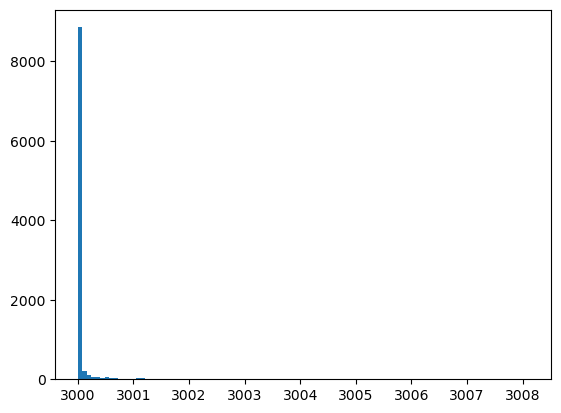

In [118]:
vel_flat = samples[:,0]
mass_flat = samples[:,1]

plt.hist(vel_flat, bins = 100)
plt.show()

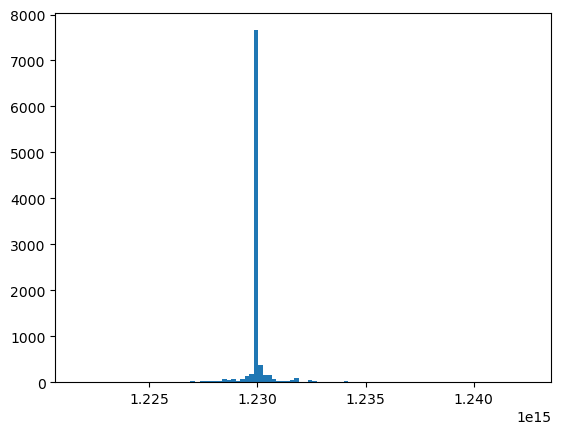

In [119]:
plt.hist(mass_flat, bins = 100)
plt.show()

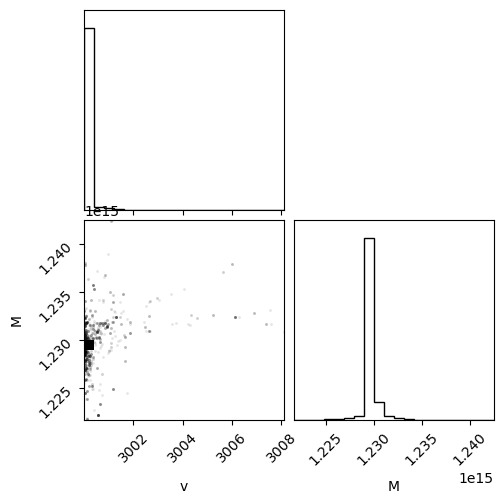

In [123]:
import corner 

labels = ["v", "M"]

fig = corner.corner(
    samples, labels = labels, truths = [4500, 1.5e15]
)

get moving lens dipole now
0.0 0.0
i=0: (ra,dec)=(0.000,0.000), mass=12.300, z=0.30
		time taken for gettting deflection vector = 5.82734743754069e-05
check me. 
		time taken for get dot product = 2.9087066650390623e-06


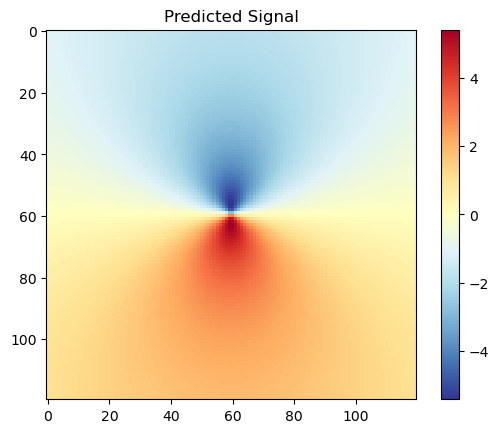

In [138]:
mvl_arr, vel_dir_arr, vel_mag_arr = moving_lens.get_moving_lens_dipole(ra_grid, dec_grid, ra_list, dec_list, [1.23e15], redshift, v_phi, [3000], param_dict, bl = bl2d)
plt.imshow(mvl_arr[0], cmap = cmap); colorbar(); title("Predicted Signal"); show()

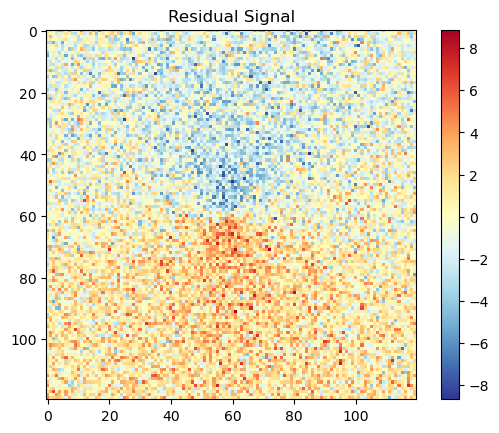

In [137]:
plt.imshow(mock_signal - mvl_arr[0], cmap = cmap); colorbar(); title("Residual Signal"); show()